# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

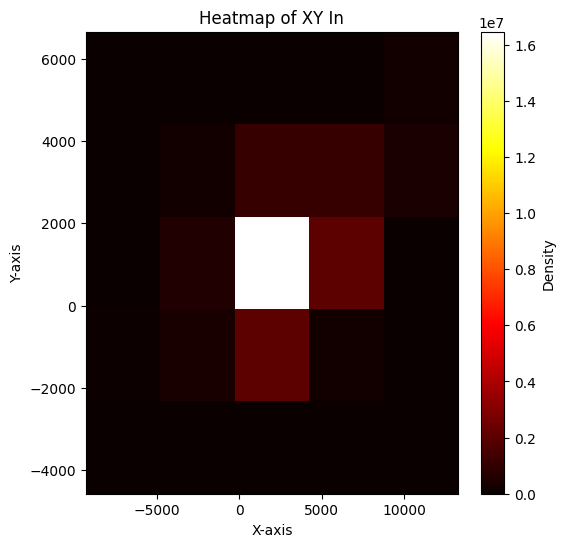

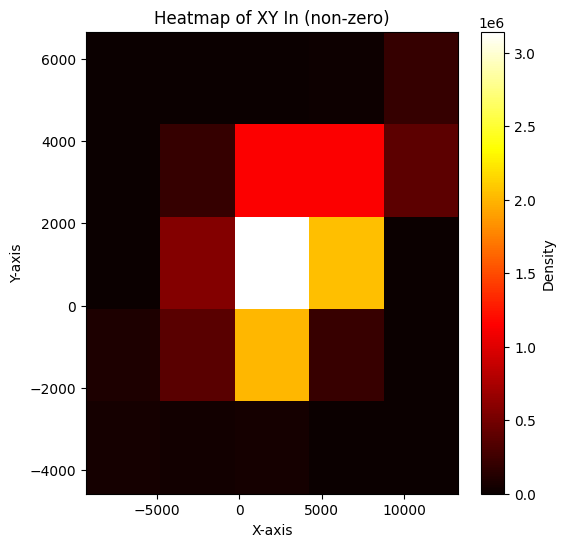

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

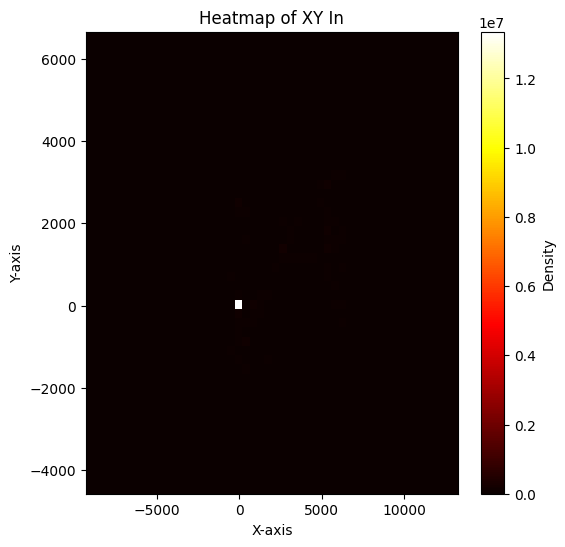

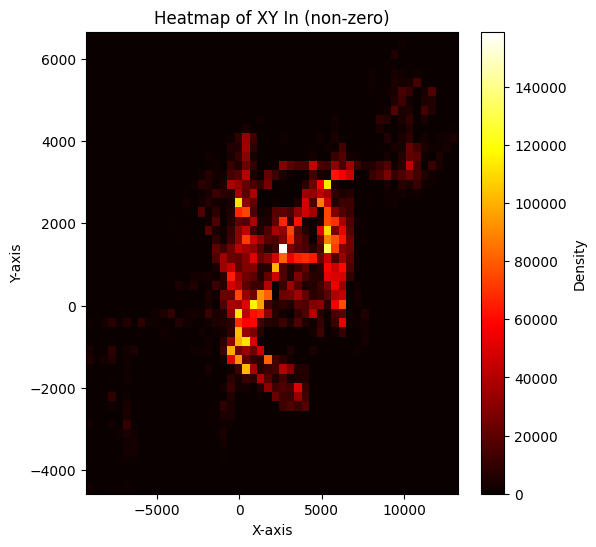

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True, input_len=50, future_len=60, sliding_window=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment
        self.input_len = input_len
        self.future_len = future_len
        self.sliding_window = sliding_window

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        total_len = scene.shape[1]  # should be 110
        # Sliding window: pick a random start if enabled
        if self.sliding_window:
            max_start = total_len - (self.input_len + self.future_len)
            t0 = np.random.randint(0, max_start + 1) if max_start > 0 else 0
        else:
            t0 = 0

        hist = scene[:, t0:t0+self.input_len, :].copy()    # (agents=50, input_len, 6)
        future = torch.tensor(scene[0, t0+self.input_len:t0+self.input_len+self.future_len, :2].copy(), dtype=torch.float32)  # (future_len, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [10]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [13]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [14]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [15]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [16]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
# model_dim=128, num_heads=4, num_layers=2


In [17]:
from s4.models.s4.s4d import S4D

class S4TrajectoryModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=128,
        num_layers=2,
        seq_len=50,
        future_len=60,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.s4_layers = nn.ModuleList([
            S4D(model_dim, dropout=dropout, transposed=True) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(model_dim)
        self.head = nn.Linear(model_dim, future_len * 2)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x.transpose(1, 2)   # (batch, model_dim, seq) for S4D
        for layer in self.s4_layers:
            x, _ = layer(x)
        x = x.transpose(1, 2)   # (batch, seq, model_dim)
        x = self.norm(x[:, -1, :])  # Use last time step
        out = self.head(x)
        return out.view(-1, self.future_len, 2)

In [18]:
from s4.models.s4.s4d import S4D

class PureS4TrajectoryModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, model_dim, seq_len))
        self.s4_layers = nn.ModuleList([
            S4D(model_dim, dropout=dropout, transposed=True) for _ in range(num_layers)
        ])
        self.norms_pre = nn.ModuleList([nn.LayerNorm(model_dim) for _ in range(num_layers)])
        self.norms_post = nn.ModuleList([nn.LayerNorm(model_dim) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim * 2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x.transpose(1, 2)   # (batch, model_dim, seq)
        x = x + self.pos_encoding[:, :, :x.shape[-1]]

        for i, s4 in enumerate(self.s4_layers):
            x_in = self.norms_pre[i](x.transpose(1, 2)).transpose(1, 2)
            x_out, _ = s4(x_in)
            x = x_in + self.dropout(x_out)  # Residual + dropout
            x = self.norms_post[i](x.transpose(1, 2)).transpose(1, 2)

        x = x.transpose(1, 2)   # (batch, seq, model_dim)
        x = self.dropout(x[:, -1, :])  # Last time step + dropout
        out = self.head(x)
        return out.view(-1, self.future_len, 2)

In [19]:
from torch_geometric.nn import GATConv
from s4.models.s4.s4d import S4D

class GNNS4TrajectoryModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        gnn_hidden=64,
        gnn_heads=2,
        s4_dim=128,
        s4_layers=2,
        seq_len=50,
        future_len=60,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # GNN for agent interaction at last timestep
        self.gnn_input = nn.Linear(input_dim, gnn_hidden)
        self.gnn = GATConv(gnn_hidden, gnn_hidden, heads=gnn_heads, dropout=dropout)
        self.gnn_norm = nn.LayerNorm(gnn_hidden * gnn_heads)

        # S4 for ego temporal encoding
        self.s4_input = nn.Linear(input_dim, s4_dim)
        self.s4_layers = nn.ModuleList([
            S4D(s4_dim, dropout=dropout, transposed=True) for _ in range(s4_layers)
        ])
        self.s4_norms = nn.ModuleList([nn.LayerNorm(s4_dim) for _ in range(s4_layers)])
        self.s4_dropout = nn.Dropout(dropout)
        self.pos_encoding = nn.Parameter(torch.randn(1, s4_dim, seq_len))

        # Final fusion and prediction
        self.fc = nn.Sequential(
            nn.Linear(gnn_hidden * gnn_heads + s4_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        batch_size = x.shape[0]
        num_agents = x.shape[1]

        # --- GNN: agent interaction at last timestep ---
        last_timestep = x[:, :, -1, :]  # (batch, agents, features)
        gnn_in = self.gnn_input(last_timestep)  # (batch, agents, gnn_hidden)
        edge_index = torch.combinations(torch.arange(num_agents), r=2).t().to(x.device)
        gnn_out = []
        for b in range(batch_size):
            h = self.gnn(gnn_in[b], edge_index)
            h = self.gnn_norm(h)
            gnn_out.append(h[0])  # Use ego agent (index 0)
        gnn_out = torch.stack(gnn_out, dim=0)  # (batch, gnn_hidden * gnn_heads)

        # --- S4: ego agent temporal encoding ---
        ego_traj = x[:, 0, :, :]  # (batch, seq, features)
        s4_in = self.s4_input(ego_traj)  # (batch, seq, s4_dim)
        s4_in = s4_in.transpose(1, 2)  # (batch, s4_dim, seq)
        s4_in = s4_in + self.pos_encoding[:, :, :s4_in.shape[-1]]  # Add positional encoding

        for i, s4 in enumerate(self.s4_layers):
            # LayerNorm before S4
            s4_in = self.s4_norms[i](s4_in.transpose(1, 2)).transpose(1, 2)
            s4_out, _ = s4(s4_in)
            s4_in = s4_in + s4_out  # Residual connection

        s4_in = s4_in.transpose(1, 2)  # (batch, seq, s4_dim)
        s4_out = self.s4_dropout(s4_in[:, -1, :])  # Last time step + dropout

        # --- Concatenate and predict ---
        fused = torch.cat([gnn_out, s4_out], dim=-1)
        out = self.fc(fused)
        return out.view(-1, self.future_len, 2)

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [20]:
from sklearn.model_selection import KFold

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_indices = np.arange(len(train_data))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # Create datasets for this fold
    train_dataset = TrajectoryDatasetTrain(train_data[train_idx], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False, sliding_window=False)
    train_dataloader = DataLoader(
        train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    model = PureS4TrajectoryModel(dropout=0).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
    early_stopping_patience = 20
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()

    for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

    fold_results.append(best_val_loss)

print(f"\nK-Fold Results: {fold_results}")
print(f"Mean Validation Loss: {np.mean(fold_results):.4f} | Std: {np.std(fold_results):.4f}")


--- Fold 1/5 ---


Epoch:   1%|          | 1/100 [00:05<08:56,  5.42s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.0304 | val normalized MSE   0.4060, | val MAE   2.7306 | val MSE  19.8936


Epoch:   2%|▏         | 2/100 [00:10<08:11,  5.01s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.4133 | val normalized MSE   0.3525, | val MAE   2.4420 | val MSE  17.2723


Epoch:   3%|▎         | 3/100 [00:14<07:48,  4.83s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3422 | val normalized MSE   0.2950, | val MAE   2.0461 | val MSE  14.4567


Epoch:   4%|▍         | 4/100 [00:19<07:42,  4.81s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3244 | val normalized MSE   0.3653, | val MAE   2.4559 | val MSE  17.9013


Epoch:   5%|▌         | 5/100 [00:24<07:42,  4.87s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2932 | val normalized MSE   0.2776, | val MAE   2.0296 | val MSE  13.6040


Epoch:   6%|▌         | 6/100 [00:29<07:43,  4.93s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2989 | val normalized MSE   0.2942, | val MAE   2.1257 | val MSE  14.4162


Epoch:   7%|▋         | 7/100 [00:34<07:39,  4.94s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2849 | val normalized MSE   0.3259, | val MAE   2.4344 | val MSE  15.9694


Epoch:   8%|▊         | 8/100 [00:39<07:38,  4.98s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2797 | val normalized MSE   0.2945, | val MAE   2.1099 | val MSE  14.4327


Epoch:   9%|▉         | 9/100 [00:44<07:36,  5.02s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2627 | val normalized MSE   0.2615, | val MAE   1.8784 | val MSE  12.8140


Epoch:  10%|█         | 10/100 [00:49<07:36,  5.07s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2702 | val normalized MSE   0.2723, | val MAE   2.0737 | val MSE  13.3420


Epoch:  11%|█         | 11/100 [00:54<07:24,  4.99s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2804 | val normalized MSE   0.2432, | val MAE   1.8075 | val MSE  11.9183


Epoch:  12%|█▏        | 12/100 [00:59<07:11,  4.91s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2619 | val normalized MSE   0.2587, | val MAE   1.9488 | val MSE  12.6760


Epoch:  13%|█▎        | 13/100 [01:04<07:14,  5.00s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2558 | val normalized MSE   0.2712, | val MAE   2.0750 | val MSE  13.2881


Epoch:  14%|█▍        | 14/100 [01:09<07:17,  5.09s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2501 | val normalized MSE   0.2644, | val MAE   1.9343 | val MSE  12.9532


Epoch:  15%|█▌        | 15/100 [01:14<07:09,  5.05s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2575 | val normalized MSE   0.2364, | val MAE   1.7379 | val MSE  11.5817


Epoch:  16%|█▌        | 16/100 [01:19<06:55,  4.94s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2458 | val normalized MSE   0.2852, | val MAE   2.2241 | val MSE  13.9762


Epoch:  17%|█▋        | 17/100 [01:24<06:51,  4.95s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2512 | val normalized MSE   0.2466, | val MAE   1.9373 | val MSE  12.0831


Epoch:  18%|█▊        | 18/100 [01:29<06:46,  4.95s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2409 | val normalized MSE   0.2329, | val MAE   1.8610 | val MSE  11.4130


Epoch:  19%|█▉        | 19/100 [01:34<06:46,  5.02s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2447 | val normalized MSE   0.2529, | val MAE   1.8718 | val MSE  12.3940


Epoch:  20%|██        | 20/100 [01:39<06:36,  4.95s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2357 | val normalized MSE   0.2268, | val MAE   1.7510 | val MSE  11.1147


Epoch:  21%|██        | 21/100 [01:44<06:29,  4.94s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2131 | val normalized MSE   0.2128, | val MAE   1.6407 | val MSE  10.4256


Epoch:  22%|██▏       | 22/100 [01:49<06:28,  4.98s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2083 | val normalized MSE   0.2211, | val MAE   1.7025 | val MSE  10.8343


Epoch:  23%|██▎       | 23/100 [01:54<06:29,  5.05s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2082 | val normalized MSE   0.2075, | val MAE   1.5887 | val MSE  10.1698


Epoch:  24%|██▍       | 24/100 [01:59<06:21,  5.02s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2076 | val normalized MSE   0.2210, | val MAE   1.6691 | val MSE  10.8268


Epoch:  25%|██▌       | 25/100 [02:04<06:11,  4.96s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2064 | val normalized MSE   0.2066, | val MAE   1.5382 | val MSE  10.1233


Epoch:  26%|██▌       | 26/100 [02:09<06:16,  5.08s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2078 | val normalized MSE   0.2069, | val MAE   1.5325 | val MSE  10.1385


Epoch:  27%|██▋       | 27/100 [02:15<06:15,  5.14s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2052 | val normalized MSE   0.2068, | val MAE   1.5623 | val MSE  10.1355


Epoch:  28%|██▊       | 28/100 [02:20<06:07,  5.11s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2049 | val normalized MSE   0.2096, | val MAE   1.6334 | val MSE  10.2723


Epoch:  29%|██▉       | 29/100 [02:25<06:01,  5.10s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2112 | val normalized MSE   0.2056, | val MAE   1.5228 | val MSE  10.0736


Epoch:  30%|███       | 30/100 [02:30<06:02,  5.18s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2059 | val normalized MSE   0.2027, | val MAE   1.5379 | val MSE   9.9324


Epoch:  31%|███       | 31/100 [02:35<05:54,  5.14s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2051 | val normalized MSE   0.2094, | val MAE   1.6000 | val MSE  10.2628


Epoch:  32%|███▏      | 32/100 [02:40<05:47,  5.11s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2048 | val normalized MSE   0.2041, | val MAE   1.5086 | val MSE  10.0003


Epoch:  33%|███▎      | 33/100 [02:45<05:44,  5.15s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2038 | val normalized MSE   0.2139, | val MAE   1.6786 | val MSE  10.4805


Epoch:  34%|███▍      | 34/100 [02:51<05:42,  5.18s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2028 | val normalized MSE   0.2036, | val MAE   1.5314 | val MSE   9.9776


Epoch:  35%|███▌      | 35/100 [02:56<05:37,  5.19s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2063 | val normalized MSE   0.2021, | val MAE   1.5244 | val MSE   9.9029


Epoch:  36%|███▌      | 36/100 [03:01<05:28,  5.13s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2036 | val normalized MSE   0.2012, | val MAE   1.4826 | val MSE   9.8575


Epoch:  37%|███▋      | 37/100 [03:06<05:20,  5.09s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2013 | val normalized MSE   0.2086, | val MAE   1.5819 | val MSE  10.2235


Epoch:  38%|███▊      | 38/100 [03:11<05:15,  5.08s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2019 | val normalized MSE   0.2135, | val MAE   1.6530 | val MSE  10.4592


Epoch:  39%|███▉      | 39/100 [03:16<05:11,  5.10s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2025 | val normalized MSE   0.2003, | val MAE   1.5080 | val MSE   9.8124


Epoch:  40%|████      | 40/100 [03:21<05:04,  5.08s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2054 | val normalized MSE   0.2196, | val MAE   1.7028 | val MSE  10.7581


Epoch:  41%|████      | 41/100 [03:26<04:55,  5.02s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1941 | val normalized MSE   0.1968, | val MAE   1.4718 | val MSE   9.6413


Epoch:  42%|████▏     | 42/100 [03:31<04:46,  4.94s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1929 | val normalized MSE   0.1962, | val MAE   1.4686 | val MSE   9.6135


Epoch:  43%|████▎     | 43/100 [03:36<04:43,  4.97s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1910 | val normalized MSE   0.1967, | val MAE   1.4953 | val MSE   9.6397


Epoch:  44%|████▍     | 44/100 [03:41<04:39,  4.99s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1915 | val normalized MSE   0.1993, | val MAE   1.5101 | val MSE   9.7674


Epoch:  45%|████▌     | 45/100 [03:46<04:33,  4.96s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1908 | val normalized MSE   0.1973, | val MAE   1.4742 | val MSE   9.6674


Epoch:  46%|████▌     | 46/100 [03:50<04:24,  4.89s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1907 | val normalized MSE   0.1964, | val MAE   1.4808 | val MSE   9.6250


Epoch:  47%|████▋     | 47/100 [03:55<04:21,  4.94s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1904 | val normalized MSE   0.1951, | val MAE   1.4431 | val MSE   9.5614


Epoch:  48%|████▊     | 48/100 [04:01<04:20,  5.01s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1902 | val normalized MSE   0.1938, | val MAE   1.4515 | val MSE   9.4958


Epoch:  49%|████▉     | 49/100 [04:06<04:16,  5.04s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1902 | val normalized MSE   0.1950, | val MAE   1.4479 | val MSE   9.5540


Epoch:  50%|█████     | 50/100 [04:11<04:09,  5.00s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1907 | val normalized MSE   0.1963, | val MAE   1.4506 | val MSE   9.6174


Epoch:  51%|█████     | 51/100 [04:16<04:03,  4.97s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1904 | val normalized MSE   0.1978, | val MAE   1.4813 | val MSE   9.6915


Epoch:  52%|█████▏    | 52/100 [04:21<03:59,  4.98s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1902 | val normalized MSE   0.1936, | val MAE   1.4521 | val MSE   9.4880


Epoch:  53%|█████▎    | 53/100 [04:25<03:52,  4.95s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1898 | val normalized MSE   0.1954, | val MAE   1.4794 | val MSE   9.5723


Epoch:  54%|█████▍    | 54/100 [04:30<03:44,  4.87s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1908 | val normalized MSE   0.1966, | val MAE   1.4922 | val MSE   9.6341


Epoch:  55%|█████▌    | 55/100 [04:35<03:40,  4.91s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1905 | val normalized MSE   0.2011, | val MAE   1.5790 | val MSE   9.8515


Epoch:  56%|█████▌    | 56/100 [04:40<03:39,  5.00s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1898 | val normalized MSE   0.1954, | val MAE   1.4466 | val MSE   9.5761


Epoch:  57%|█████▋    | 57/100 [04:46<03:37,  5.05s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1890 | val normalized MSE   0.1951, | val MAE   1.4638 | val MSE   9.5623


Epoch:  58%|█████▊    | 58/100 [04:50<03:30,  5.01s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1897 | val normalized MSE   0.1943, | val MAE   1.4488 | val MSE   9.5213


Epoch:  59%|█████▉    | 59/100 [04:55<03:22,  4.94s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1892 | val normalized MSE   0.1967, | val MAE   1.4800 | val MSE   9.6374


Epoch:  60%|██████    | 60/100 [05:00<03:19,  5.00s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1889 | val normalized MSE   0.1966, | val MAE   1.4603 | val MSE   9.6316


Epoch:  61%|██████    | 61/100 [05:06<03:17,  5.07s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1871 | val normalized MSE   0.1923, | val MAE   1.4262 | val MSE   9.4230


Epoch:  62%|██████▏   | 62/100 [05:10<03:09,  4.99s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1854 | val normalized MSE   0.1921, | val MAE   1.4267 | val MSE   9.4136


Epoch:  63%|██████▎   | 63/100 [05:15<03:02,  4.94s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1859 | val normalized MSE   0.1931, | val MAE   1.4320 | val MSE   9.4624


Epoch:  64%|██████▍   | 64/100 [05:20<02:57,  4.94s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1863 | val normalized MSE   0.1927, | val MAE   1.4324 | val MSE   9.4440


Epoch:  65%|██████▌   | 65/100 [05:25<02:54,  4.99s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1865 | val normalized MSE   0.1926, | val MAE   1.4307 | val MSE   9.4360


Epoch:  66%|██████▌   | 66/100 [05:30<02:49,  5.00s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1859 | val normalized MSE   0.1939, | val MAE   1.4563 | val MSE   9.5009


Epoch:  67%|██████▋   | 67/100 [05:35<02:42,  4.93s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1857 | val normalized MSE   0.1931, | val MAE   1.4372 | val MSE   9.4611


Epoch:  68%|██████▊   | 68/100 [05:40<02:36,  4.88s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1932, | val MAE   1.4452 | val MSE   9.4670


Epoch:  69%|██████▉   | 69/100 [05:45<02:36,  5.06s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1866 | val normalized MSE   0.1925, | val MAE   1.4442 | val MSE   9.4325


Epoch:  70%|███████   | 70/100 [05:50<02:33,  5.11s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1868 | val normalized MSE   0.1925, | val MAE   1.4343 | val MSE   9.4315


Epoch:  71%|███████   | 71/100 [05:55<02:24,  4.98s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1859 | val normalized MSE   0.1931, | val MAE   1.4447 | val MSE   9.4640


Epoch:  72%|███████▏  | 72/100 [06:00<02:19,  4.99s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1855 | val normalized MSE   0.1917, | val MAE   1.4219 | val MSE   9.3909


Epoch:  73%|███████▎  | 73/100 [06:05<02:15,  5.03s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1860 | val normalized MSE   0.1922, | val MAE   1.4269 | val MSE   9.4164


Epoch:  74%|███████▍  | 74/100 [06:10<02:11,  5.05s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1854 | val normalized MSE   0.1921, | val MAE   1.4235 | val MSE   9.4111


Epoch:  75%|███████▌  | 75/100 [06:15<02:06,  5.04s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1860 | val normalized MSE   0.1923, | val MAE   1.4250 | val MSE   9.4217


Epoch:  76%|███████▌  | 76/100 [06:20<01:59,  4.97s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1863 | val normalized MSE   0.1933, | val MAE   1.4433 | val MSE   9.4712


Epoch:  77%|███████▋  | 77/100 [06:25<01:52,  4.90s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1862 | val normalized MSE   0.1935, | val MAE   1.4647 | val MSE   9.4838


Epoch:  78%|███████▊  | 78/100 [06:30<01:49,  4.98s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1852 | val normalized MSE   0.1936, | val MAE   1.4298 | val MSE   9.4873


Epoch:  79%|███████▉  | 79/100 [06:35<01:44,  4.99s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1860 | val normalized MSE   0.1922, | val MAE   1.4236 | val MSE   9.4166


Epoch:  80%|████████  | 80/100 [06:40<01:38,  4.93s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1860 | val normalized MSE   0.1924, | val MAE   1.4282 | val MSE   9.4280


Epoch:  81%|████████  | 81/100 [06:45<01:34,  4.98s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1844 | val normalized MSE   0.1919, | val MAE   1.4223 | val MSE   9.4020


Epoch:  82%|████████▏ | 82/100 [06:50<01:30,  5.02s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1840 | val normalized MSE   0.1919, | val MAE   1.4253 | val MSE   9.4014


Epoch:  83%|████████▎ | 83/100 [06:55<01:26,  5.06s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1918, | val MAE   1.4165 | val MSE   9.3991


Epoch:  84%|████████▍ | 84/100 [07:00<01:20,  5.06s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1849 | val normalized MSE   0.1918, | val MAE   1.4189 | val MSE   9.3986


Epoch:  85%|████████▌ | 85/100 [07:05<01:14,  4.97s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1846 | val normalized MSE   0.1916, | val MAE   1.4166 | val MSE   9.3873


Epoch:  86%|████████▌ | 86/100 [07:10<01:09,  4.98s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1843 | val normalized MSE   0.1914, | val MAE   1.4176 | val MSE   9.3769


Epoch:  87%|████████▋ | 87/100 [07:15<01:04,  4.96s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1841 | val normalized MSE   0.1919, | val MAE   1.4282 | val MSE   9.4036


Epoch:  88%|████████▊ | 88/100 [07:20<00:59,  4.97s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1850 | val normalized MSE   0.1913, | val MAE   1.4234 | val MSE   9.3736


Epoch:  89%|████████▉ | 89/100 [07:25<00:54,  4.92s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1841 | val normalized MSE   0.1914, | val MAE   1.4211 | val MSE   9.3763


Epoch:  90%|█████████ | 90/100 [07:30<00:48,  4.89s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1844 | val normalized MSE   0.1916, | val MAE   1.4202 | val MSE   9.3892


Epoch:  91%|█████████ | 91/100 [07:35<00:45,  5.00s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1852 | val normalized MSE   0.1921, | val MAE   1.4179 | val MSE   9.4150


Epoch:  92%|█████████▏| 92/100 [07:40<00:40,  5.02s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1842 | val normalized MSE   0.1917, | val MAE   1.4224 | val MSE   9.3920


Epoch:  93%|█████████▎| 93/100 [07:45<00:35,  5.03s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1917, | val MAE   1.4218 | val MSE   9.3954


Epoch:  94%|█████████▍| 94/100 [07:50<00:30,  5.00s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1848 | val normalized MSE   0.1919, | val MAE   1.4332 | val MSE   9.4041


Epoch:  95%|█████████▌| 95/100 [07:55<00:25,  5.07s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1845 | val normalized MSE   0.1918, | val MAE   1.4360 | val MSE   9.3981


Epoch:  96%|█████████▌| 96/100 [08:00<00:20,  5.06s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1842 | val normalized MSE   0.1916, | val MAE   1.4198 | val MSE   9.3866


Epoch:  97%|█████████▋| 97/100 [08:05<00:15,  5.07s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1843 | val normalized MSE   0.1916, | val MAE   1.4177 | val MSE   9.3896


Epoch:  98%|█████████▊| 98/100 [08:10<00:10,  5.10s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1846 | val normalized MSE   0.1917, | val MAE   1.4178 | val MSE   9.3946


Epoch:  99%|█████████▉| 99/100 [08:16<00:05,  5.11s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1843 | val normalized MSE   0.1915, | val MAE   1.4182 | val MSE   9.3842


Epoch: 100%|██████████| 100/100 [08:21<00:00,  5.01s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1841 | val normalized MSE   0.1919, | val MAE   1.4211 | val MSE   9.4018

--- Fold 2/5 ---


Epoch:   1%|          | 1/100 [00:05<08:47,  5.33s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.0017 | val normalized MSE   0.3290, | val MAE   2.2637 | val MSE  16.1227


Epoch:   2%|▏         | 2/100 [00:10<08:16,  5.07s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3806 | val normalized MSE   0.3164, | val MAE   2.2766 | val MSE  15.5032


Epoch:   3%|▎         | 3/100 [00:15<08:17,  5.13s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3269 | val normalized MSE   0.3719, | val MAE   2.5502 | val MSE  18.2209


Epoch:   4%|▍         | 4/100 [00:20<08:12,  5.13s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3207 | val normalized MSE   0.3153, | val MAE   2.2048 | val MSE  15.4512


Epoch:   5%|▌         | 5/100 [00:25<08:05,  5.11s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2880 | val normalized MSE   0.2811, | val MAE   2.1412 | val MSE  13.7734


Epoch:   6%|▌         | 6/100 [00:30<07:51,  5.02s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2948 | val normalized MSE   0.2800, | val MAE   2.1104 | val MSE  13.7220


Epoch:   7%|▋         | 7/100 [00:35<07:51,  5.07s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2890 | val normalized MSE   0.2736, | val MAE   1.9514 | val MSE  13.4058


Epoch:   8%|▊         | 8/100 [00:40<07:53,  5.14s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2788 | val normalized MSE   0.2667, | val MAE   2.0445 | val MSE  13.0667


Epoch:   9%|▉         | 9/100 [00:46<07:48,  5.14s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2748 | val normalized MSE   0.2536, | val MAE   1.9377 | val MSE  12.4258


Epoch:  10%|█         | 10/100 [00:51<07:36,  5.08s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2767 | val normalized MSE   0.2675, | val MAE   1.9241 | val MSE  13.1085


Epoch:  11%|█         | 11/100 [00:56<07:29,  5.06s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2673 | val normalized MSE   0.2858, | val MAE   2.1076 | val MSE  14.0037


Epoch:  12%|█▏        | 12/100 [01:01<07:29,  5.11s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2724 | val normalized MSE   0.2559, | val MAE   1.9332 | val MSE  12.5375


Epoch:  13%|█▎        | 13/100 [01:06<07:20,  5.06s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2517 | val normalized MSE   0.2447, | val MAE   1.7861 | val MSE  11.9886


Epoch:  14%|█▍        | 14/100 [01:11<07:12,  5.03s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2527 | val normalized MSE   0.2349, | val MAE   1.7533 | val MSE  11.5090


Epoch:  15%|█▌        | 15/100 [01:16<07:03,  4.98s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2555 | val normalized MSE   0.2438, | val MAE   1.9066 | val MSE  11.9458


Epoch:  16%|█▌        | 16/100 [01:21<07:03,  5.05s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2551 | val normalized MSE   0.2328, | val MAE   1.7382 | val MSE  11.4085


Epoch:  17%|█▋        | 17/100 [01:26<06:55,  5.01s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2425 | val normalized MSE   0.2540, | val MAE   1.9516 | val MSE  12.4482


Epoch:  18%|█▊        | 18/100 [01:31<06:50,  5.01s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2527 | val normalized MSE   0.2442, | val MAE   1.7746 | val MSE  11.9649


Epoch:  19%|█▉        | 19/100 [01:35<06:39,  4.94s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2502 | val normalized MSE   0.2494, | val MAE   1.9121 | val MSE  12.2190


Epoch:  20%|██        | 20/100 [01:40<06:35,  4.94s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2480 | val normalized MSE   0.2462, | val MAE   1.8556 | val MSE  12.0623


Epoch:  21%|██        | 21/100 [01:46<06:35,  5.00s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2155 | val normalized MSE   0.2200, | val MAE   1.6481 | val MSE  10.7808


Epoch:  22%|██▏       | 22/100 [01:51<06:30,  5.00s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2130 | val normalized MSE   0.2104, | val MAE   1.5545 | val MSE  10.3095


Epoch:  23%|██▎       | 23/100 [01:55<06:23,  4.98s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2131 | val normalized MSE   0.2106, | val MAE   1.5579 | val MSE  10.3181


Epoch:  24%|██▍       | 24/100 [02:00<06:17,  4.97s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2119 | val normalized MSE   0.2196, | val MAE   1.6273 | val MSE  10.7599


Epoch:  25%|██▌       | 25/100 [02:06<06:17,  5.04s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2121 | val normalized MSE   0.2163, | val MAE   1.6094 | val MSE  10.6004


Epoch:  26%|██▌       | 26/100 [02:11<06:14,  5.06s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2100 | val normalized MSE   0.2082, | val MAE   1.5661 | val MSE  10.2026


Epoch:  27%|██▋       | 27/100 [02:15<06:03,  4.97s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2103 | val normalized MSE   0.2152, | val MAE   1.6397 | val MSE  10.5452


Epoch:  28%|██▊       | 28/100 [02:20<05:54,  4.92s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2128 | val normalized MSE   0.2216, | val MAE   1.7061 | val MSE  10.8576


Epoch:  29%|██▉       | 29/100 [02:26<05:56,  5.02s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2108 | val normalized MSE   0.2194, | val MAE   1.6498 | val MSE  10.7530


Epoch:  30%|███       | 30/100 [02:31<05:52,  5.03s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2112 | val normalized MSE   0.2062, | val MAE   1.5673 | val MSE  10.1061


Epoch:  31%|███       | 31/100 [02:36<05:46,  5.03s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2094 | val normalized MSE   0.2098, | val MAE   1.5450 | val MSE  10.2821


Epoch:  32%|███▏      | 32/100 [02:40<05:35,  4.93s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2156 | val normalized MSE   0.2064, | val MAE   1.5889 | val MSE  10.1133


Epoch:  33%|███▎      | 33/100 [02:45<05:34,  4.99s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2085 | val normalized MSE   0.2094, | val MAE   1.6182 | val MSE  10.2613


Epoch:  34%|███▍      | 34/100 [02:50<05:29,  4.99s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2083 | val normalized MSE   0.2095, | val MAE   1.6066 | val MSE  10.2658


Epoch:  35%|███▌      | 35/100 [02:55<05:22,  4.96s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2073 | val normalized MSE   0.2157, | val MAE   1.7245 | val MSE  10.5699


Epoch:  36%|███▌      | 36/100 [03:00<05:13,  4.90s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2076 | val normalized MSE   0.2095, | val MAE   1.6238 | val MSE  10.2668


Epoch:  37%|███▋      | 37/100 [03:05<05:06,  4.87s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2072 | val normalized MSE   0.2081, | val MAE   1.5951 | val MSE  10.1993


Epoch:  38%|███▊      | 38/100 [03:10<05:05,  4.93s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2068 | val normalized MSE   0.2161, | val MAE   1.6731 | val MSE  10.5872


Epoch:  39%|███▉      | 39/100 [03:15<05:05,  5.01s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2068 | val normalized MSE   0.2100, | val MAE   1.5985 | val MSE  10.2877


Epoch:  40%|████      | 40/100 [03:20<04:57,  4.96s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2046 | val normalized MSE   0.2058, | val MAE   1.5508 | val MSE  10.0864


Epoch:  41%|████      | 41/100 [03:25<04:55,  5.00s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1986 | val normalized MSE   0.1999, | val MAE   1.4784 | val MSE   9.7964


Epoch:  42%|████▏     | 42/100 [03:30<04:55,  5.09s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1976 | val normalized MSE   0.1987, | val MAE   1.4905 | val MSE   9.7351


Epoch:  43%|████▎     | 43/100 [03:35<04:49,  5.08s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1965 | val normalized MSE   0.1972, | val MAE   1.4593 | val MSE   9.6614


Epoch:  44%|████▍     | 44/100 [03:40<04:41,  5.02s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1964 | val normalized MSE   0.2003, | val MAE   1.4915 | val MSE   9.8140


Epoch:  45%|████▌     | 45/100 [03:45<04:33,  4.97s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1958 | val normalized MSE   0.2015, | val MAE   1.5451 | val MSE   9.8713


Epoch:  46%|████▌     | 46/100 [03:50<04:29,  5.00s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1959 | val normalized MSE   0.2016, | val MAE   1.4936 | val MSE   9.8761


Epoch:  47%|████▋     | 47/100 [03:55<04:26,  5.03s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1974 | val normalized MSE   0.2016, | val MAE   1.5367 | val MSE   9.8763


Epoch:  48%|████▊     | 48/100 [04:00<04:20,  5.02s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1947 | val normalized MSE   0.1974, | val MAE   1.4662 | val MSE   9.6737


Epoch:  49%|████▉     | 49/100 [04:05<04:16,  5.02s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1956 | val normalized MSE   0.1974, | val MAE   1.4783 | val MSE   9.6714


Epoch:  50%|█████     | 50/100 [04:10<04:10,  5.01s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1949 | val normalized MSE   0.1974, | val MAE   1.4910 | val MSE   9.6739


Epoch:  51%|█████     | 51/100 [04:15<04:07,  5.04s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1945 | val normalized MSE   0.1976, | val MAE   1.4801 | val MSE   9.6800


Epoch:  52%|█████▏    | 52/100 [04:20<04:00,  5.02s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1945 | val normalized MSE   0.1948, | val MAE   1.4717 | val MSE   9.5459


Epoch:  53%|█████▎    | 53/100 [04:25<03:54,  4.99s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1949 | val normalized MSE   0.1981, | val MAE   1.4734 | val MSE   9.7051


Epoch:  54%|█████▍    | 54/100 [04:31<03:52,  5.05s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1948 | val normalized MSE   0.1993, | val MAE   1.4927 | val MSE   9.7644


Epoch:  55%|█████▌    | 55/100 [04:36<03:48,  5.08s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1936 | val normalized MSE   0.1959, | val MAE   1.5022 | val MSE   9.5998


Epoch:  56%|█████▌    | 56/100 [04:41<03:42,  5.06s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1937 | val normalized MSE   0.1967, | val MAE   1.5001 | val MSE   9.6403


Epoch:  57%|█████▋    | 57/100 [04:46<03:36,  5.04s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1944 | val normalized MSE   0.2001, | val MAE   1.5646 | val MSE   9.8049


Epoch:  58%|█████▊    | 58/100 [04:51<03:29,  5.00s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1951 | val normalized MSE   0.2004, | val MAE   1.5446 | val MSE   9.8219


Epoch:  59%|█████▉    | 59/100 [04:56<03:25,  5.00s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1939 | val normalized MSE   0.1947, | val MAE   1.4819 | val MSE   9.5419


Epoch:  60%|██████    | 60/100 [05:00<03:17,  4.94s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1930 | val normalized MSE   0.1961, | val MAE   1.4766 | val MSE   9.6092


Epoch:  61%|██████    | 61/100 [05:05<03:09,  4.85s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1916 | val normalized MSE   0.1942, | val MAE   1.4458 | val MSE   9.5154


Epoch:  62%|██████▏   | 62/100 [05:10<03:02,  4.80s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1920 | val normalized MSE   0.1941, | val MAE   1.4556 | val MSE   9.5090


Epoch:  63%|██████▎   | 63/100 [05:14<02:55,  4.76s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1912 | val normalized MSE   0.1943, | val MAE   1.4540 | val MSE   9.5228


Epoch:  64%|██████▍   | 64/100 [05:19<02:53,  4.81s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1909 | val normalized MSE   0.1935, | val MAE   1.4448 | val MSE   9.4810


Epoch:  65%|██████▌   | 65/100 [05:24<02:48,  4.82s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1912 | val normalized MSE   0.1928, | val MAE   1.4421 | val MSE   9.4456


Epoch:  66%|██████▌   | 66/100 [05:29<02:44,  4.83s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1909 | val normalized MSE   0.1925, | val MAE   1.4378 | val MSE   9.4317


Epoch:  67%|██████▋   | 67/100 [05:34<02:39,  4.83s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1913 | val normalized MSE   0.1976, | val MAE   1.5027 | val MSE   9.6837


Epoch:  68%|██████▊   | 68/100 [05:39<02:33,  4.79s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1903 | val normalized MSE   0.1928, | val MAE   1.4413 | val MSE   9.4476


Epoch:  69%|██████▉   | 69/100 [05:43<02:28,  4.80s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1909 | val normalized MSE   0.1932, | val MAE   1.4467 | val MSE   9.4669


Epoch:  70%|███████   | 70/100 [05:48<02:23,  4.77s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1914 | val normalized MSE   0.1959, | val MAE   1.4625 | val MSE   9.5980


Epoch:  71%|███████   | 71/100 [05:53<02:17,  4.74s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1907 | val normalized MSE   0.1932, | val MAE   1.4402 | val MSE   9.4672


Epoch:  72%|███████▏  | 72/100 [05:57<02:12,  4.74s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1898 | val normalized MSE   0.1928, | val MAE   1.4499 | val MSE   9.4481


Epoch:  73%|███████▎  | 73/100 [06:03<02:11,  4.88s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1904 | val normalized MSE   0.1939, | val MAE   1.4499 | val MSE   9.4997


Epoch:  74%|███████▍  | 74/100 [06:08<02:08,  4.92s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1905 | val normalized MSE   0.1945, | val MAE   1.4456 | val MSE   9.5289


Epoch:  75%|███████▌  | 75/100 [06:13<02:03,  4.92s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1908 | val normalized MSE   0.1940, | val MAE   1.4975 | val MSE   9.5053


Epoch:  76%|███████▌  | 76/100 [06:18<01:58,  4.92s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1908 | val normalized MSE   0.1935, | val MAE   1.4460 | val MSE   9.4799


Epoch:  77%|███████▋  | 77/100 [06:22<01:50,  4.81s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1896 | val normalized MSE   0.1934, | val MAE   1.4500 | val MSE   9.4787


Epoch:  78%|███████▊  | 78/100 [06:27<01:45,  4.80s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1903 | val normalized MSE   0.1935, | val MAE   1.4454 | val MSE   9.4813


Epoch:  79%|███████▉  | 79/100 [06:31<01:39,  4.75s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1906 | val normalized MSE   0.1925, | val MAE   1.4412 | val MSE   9.4301


Epoch:  80%|████████  | 80/100 [06:36<01:35,  4.77s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1904 | val normalized MSE   0.1926, | val MAE   1.4502 | val MSE   9.4362


Epoch:  81%|████████  | 81/100 [06:41<01:31,  4.79s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1887 | val normalized MSE   0.1924, | val MAE   1.4370 | val MSE   9.4290


Epoch:  82%|████████▏ | 82/100 [06:46<01:26,  4.83s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1897 | val normalized MSE   0.1925, | val MAE   1.4380 | val MSE   9.4311


Epoch:  83%|████████▎ | 83/100 [06:51<01:22,  4.88s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1894 | val normalized MSE   0.1922, | val MAE   1.4344 | val MSE   9.4185


Epoch:  84%|████████▍ | 84/100 [06:56<01:17,  4.83s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1889 | val normalized MSE   0.1927, | val MAE   1.4437 | val MSE   9.4407


Epoch:  85%|████████▌ | 85/100 [07:00<01:11,  4.79s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1891 | val normalized MSE   0.1933, | val MAE   1.4356 | val MSE   9.4708


Epoch:  86%|████████▌ | 86/100 [07:05<01:06,  4.73s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1888 | val normalized MSE   0.1925, | val MAE   1.4313 | val MSE   9.4332


Epoch:  87%|████████▋ | 87/100 [07:10<01:01,  4.76s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1887 | val normalized MSE   0.1929, | val MAE   1.4313 | val MSE   9.4512


Epoch:  88%|████████▊ | 88/100 [07:15<00:56,  4.73s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1874 | val normalized MSE   0.1924, | val MAE   1.4346 | val MSE   9.4285


Epoch:  89%|████████▉ | 89/100 [07:19<00:52,  4.76s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1888 | val normalized MSE   0.1924, | val MAE   1.4283 | val MSE   9.4297


Epoch:  90%|█████████ | 90/100 [07:24<00:48,  4.86s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1885 | val normalized MSE   0.1928, | val MAE   1.4380 | val MSE   9.4450


Epoch:  91%|█████████ | 91/100 [07:29<00:43,  4.88s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1888 | val normalized MSE   0.1926, | val MAE   1.4407 | val MSE   9.4366


Epoch:  92%|█████████▏| 92/100 [07:35<00:39,  4.95s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1886 | val normalized MSE   0.1920, | val MAE   1.4310 | val MSE   9.4060


Epoch:  93%|█████████▎| 93/100 [07:39<00:34,  4.91s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1890 | val normalized MSE   0.1927, | val MAE   1.4358 | val MSE   9.4422


Epoch:  94%|█████████▍| 94/100 [07:44<00:29,  4.85s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1882 | val normalized MSE   0.1918, | val MAE   1.4311 | val MSE   9.3999


Epoch:  95%|█████████▌| 95/100 [07:49<00:24,  4.85s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1888 | val normalized MSE   0.1926, | val MAE   1.4358 | val MSE   9.4362


Epoch:  96%|█████████▌| 96/100 [07:54<00:19,  4.92s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1896 | val normalized MSE   0.1920, | val MAE   1.4353 | val MSE   9.4072


Epoch:  97%|█████████▋| 97/100 [07:59<00:14,  4.96s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1892 | val normalized MSE   0.1929, | val MAE   1.4432 | val MSE   9.4516


Epoch:  98%|█████████▊| 98/100 [08:04<00:09,  4.95s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1898 | val normalized MSE   0.1924, | val MAE   1.4409 | val MSE   9.4279


Epoch:  99%|█████████▉| 99/100 [08:09<00:04,  4.87s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1897 | val normalized MSE   0.1924, | val MAE   1.4307 | val MSE   9.4280


Epoch: 100%|██████████| 100/100 [08:14<00:00,  4.94s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1889 | val normalized MSE   0.1930, | val MAE   1.4483 | val MSE   9.4558

--- Fold 3/5 ---


Epoch:   1%|          | 1/100 [00:05<08:41,  5.27s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   0.9924 | val normalized MSE   0.4207, | val MAE   2.9270 | val MSE  20.6155


Epoch:   2%|▏         | 2/100 [00:10<08:22,  5.13s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3762 | val normalized MSE   0.4144, | val MAE   2.8709 | val MSE  20.3054


Epoch:   3%|▎         | 3/100 [00:15<08:04,  5.00s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3156 | val normalized MSE   0.3086, | val MAE   2.2377 | val MSE  15.1212


Epoch:   4%|▍         | 4/100 [00:20<07:59,  4.99s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3132 | val normalized MSE   0.3440, | val MAE   2.3764 | val MSE  16.8581


Epoch:   5%|▌         | 5/100 [00:25<07:56,  5.02s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3099 | val normalized MSE   0.2668, | val MAE   2.0018 | val MSE  13.0726


Epoch:   6%|▌         | 6/100 [00:30<07:52,  5.03s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2944 | val normalized MSE   0.2932, | val MAE   2.1013 | val MSE  14.3652


Epoch:   7%|▋         | 7/100 [00:35<07:41,  4.97s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2699 | val normalized MSE   0.2568, | val MAE   1.8669 | val MSE  12.5816


Epoch:   8%|▊         | 8/100 [00:39<07:28,  4.87s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2845 | val normalized MSE   0.2805, | val MAE   2.1330 | val MSE  13.7437


Epoch:   9%|▉         | 9/100 [00:44<07:31,  4.96s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2712 | val normalized MSE   0.2645, | val MAE   2.0234 | val MSE  12.9628


Epoch:  10%|█         | 10/100 [00:50<07:36,  5.07s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2934 | val normalized MSE   0.2867, | val MAE   2.0766 | val MSE  14.0505


Epoch:  11%|█         | 11/100 [00:55<07:26,  5.02s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2642 | val normalized MSE   0.2588, | val MAE   1.8541 | val MSE  12.6791


Epoch:  12%|█▏        | 12/100 [01:00<07:18,  4.98s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2532 | val normalized MSE   0.2503, | val MAE   1.8169 | val MSE  12.2656


Epoch:  13%|█▎        | 13/100 [01:05<07:16,  5.02s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2574 | val normalized MSE   0.2951, | val MAE   2.2004 | val MSE  14.4591


Epoch:  14%|█▍        | 14/100 [01:10<07:16,  5.08s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2478 | val normalized MSE   0.2389, | val MAE   1.7589 | val MSE  11.7066


Epoch:  15%|█▌        | 15/100 [01:15<07:16,  5.14s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2614 | val normalized MSE   0.2487, | val MAE   1.8718 | val MSE  12.1887


Epoch:  16%|█▌        | 16/100 [01:20<07:05,  5.07s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2442 | val normalized MSE   0.2682, | val MAE   2.0168 | val MSE  13.1440


Epoch:  17%|█▋        | 17/100 [01:25<06:59,  5.05s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2444 | val normalized MSE   0.2492, | val MAE   1.9020 | val MSE  12.2117


Epoch:  18%|█▊        | 18/100 [01:30<06:53,  5.04s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2560 | val normalized MSE   0.2458, | val MAE   1.8767 | val MSE  12.0466


Epoch:  19%|█▉        | 19/100 [01:35<06:44,  4.99s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2488 | val normalized MSE   0.2289, | val MAE   1.7253 | val MSE  11.2153


Epoch:  20%|██        | 20/100 [01:40<06:35,  4.94s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2418 | val normalized MSE   0.2943, | val MAE   2.1907 | val MSE  14.4212


Epoch:  21%|██        | 21/100 [01:45<06:30,  4.94s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2198 | val normalized MSE   0.2150, | val MAE   1.5661 | val MSE  10.5370


Epoch:  22%|██▏       | 22/100 [01:50<06:30,  5.00s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2089 | val normalized MSE   0.2162, | val MAE   1.6067 | val MSE  10.5942


Epoch:  23%|██▎       | 23/100 [01:55<06:30,  5.07s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2104 | val normalized MSE   0.2151, | val MAE   1.6112 | val MSE  10.5383


Epoch:  24%|██▍       | 24/100 [02:00<06:26,  5.08s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2106 | val normalized MSE   0.2153, | val MAE   1.6023 | val MSE  10.5503


Epoch:  25%|██▌       | 25/100 [02:05<06:12,  4.97s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2098 | val normalized MSE   0.2125, | val MAE   1.5306 | val MSE  10.4103


Epoch:  26%|██▌       | 26/100 [02:10<06:12,  5.03s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2104 | val normalized MSE   0.2145, | val MAE   1.5841 | val MSE  10.5116


Epoch:  27%|██▋       | 27/100 [02:15<06:09,  5.06s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2056 | val normalized MSE   0.2218, | val MAE   1.7072 | val MSE  10.8669


Epoch:  28%|██▊       | 28/100 [02:20<06:00,  5.01s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2094 | val normalized MSE   0.2152, | val MAE   1.6524 | val MSE  10.5446


Epoch:  29%|██▉       | 29/100 [02:25<05:51,  4.95s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2067 | val normalized MSE   0.2109, | val MAE   1.6271 | val MSE  10.3342


Epoch:  30%|███       | 30/100 [02:30<05:47,  4.96s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2078 | val normalized MSE   0.2109, | val MAE   1.5911 | val MSE  10.3342


Epoch:  31%|███       | 31/100 [02:35<05:47,  5.03s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2078 | val normalized MSE   0.2077, | val MAE   1.5565 | val MSE  10.1761


Epoch:  32%|███▏      | 32/100 [02:40<05:40,  5.01s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2133 | val normalized MSE   0.2223, | val MAE   1.6751 | val MSE  10.8916


Epoch:  33%|███▎      | 33/100 [02:45<05:30,  4.93s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2071 | val normalized MSE   0.2072, | val MAE   1.5541 | val MSE  10.1521


Epoch:  34%|███▍      | 34/100 [02:50<05:22,  4.88s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2080 | val normalized MSE   0.2062, | val MAE   1.5486 | val MSE  10.1051


Epoch:  35%|███▌      | 35/100 [02:55<05:19,  4.92s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2077 | val normalized MSE   0.2081, | val MAE   1.5734 | val MSE  10.1950


Epoch:  36%|███▌      | 36/100 [03:00<05:23,  5.06s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2039 | val normalized MSE   0.2049, | val MAE   1.5404 | val MSE  10.0396


Epoch:  37%|███▋      | 37/100 [03:05<05:14,  4.99s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2022 | val normalized MSE   0.2144, | val MAE   1.6744 | val MSE  10.5077


Epoch:  38%|███▊      | 38/100 [03:09<05:02,  4.88s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2041 | val normalized MSE   0.2143, | val MAE   1.6482 | val MSE  10.5004


Epoch:  39%|███▉      | 39/100 [03:14<04:58,  4.90s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2050 | val normalized MSE   0.2142, | val MAE   1.6501 | val MSE  10.4947


Epoch:  40%|████      | 40/100 [03:19<04:57,  4.96s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2042 | val normalized MSE   0.2161, | val MAE   1.6857 | val MSE  10.5903


Epoch:  41%|████      | 41/100 [03:24<04:53,  4.97s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1958 | val normalized MSE   0.1984, | val MAE   1.4806 | val MSE   9.7207


Epoch:  42%|████▏     | 42/100 [03:29<04:47,  4.96s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1957 | val normalized MSE   0.1984, | val MAE   1.4746 | val MSE   9.7239


Epoch:  43%|████▎     | 43/100 [03:34<04:44,  4.98s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1943 | val normalized MSE   0.1971, | val MAE   1.4841 | val MSE   9.6575


Epoch:  44%|████▍     | 44/100 [03:39<04:40,  5.01s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1937 | val normalized MSE   0.2034, | val MAE   1.5227 | val MSE   9.9650


Epoch:  45%|████▌     | 45/100 [03:45<04:36,  5.02s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1945 | val normalized MSE   0.1983, | val MAE   1.4799 | val MSE   9.7174


Epoch:  46%|████▌     | 46/100 [03:49<04:25,  4.92s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1933 | val normalized MSE   0.1983, | val MAE   1.4818 | val MSE   9.7155


Epoch:  47%|████▋     | 47/100 [03:54<04:16,  4.84s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1937 | val normalized MSE   0.1972, | val MAE   1.4752 | val MSE   9.6615


Epoch:  48%|████▊     | 48/100 [03:59<04:15,  4.91s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1940 | val normalized MSE   0.1988, | val MAE   1.4915 | val MSE   9.7412


Epoch:  49%|████▉     | 49/100 [04:04<04:13,  4.98s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1936 | val normalized MSE   0.1972, | val MAE   1.4832 | val MSE   9.6621


Epoch:  50%|█████     | 50/100 [04:09<04:05,  4.91s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1914 | val normalized MSE   0.1992, | val MAE   1.4835 | val MSE   9.7600


Epoch:  51%|█████     | 51/100 [04:14<03:58,  4.87s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1933 | val normalized MSE   0.1990, | val MAE   1.5185 | val MSE   9.7519


Epoch:  52%|█████▏    | 52/100 [04:19<03:54,  4.89s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1933 | val normalized MSE   0.1973, | val MAE   1.5023 | val MSE   9.6700


Epoch:  53%|█████▎    | 53/100 [04:23<03:50,  4.90s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1928 | val normalized MSE   0.1953, | val MAE   1.4636 | val MSE   9.5698


Epoch:  54%|█████▍    | 54/100 [04:28<03:46,  4.91s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1927 | val normalized MSE   0.1967, | val MAE   1.4767 | val MSE   9.6383


Epoch:  55%|█████▌    | 55/100 [04:34<03:43,  4.97s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1912 | val normalized MSE   0.1966, | val MAE   1.4878 | val MSE   9.6348


Epoch:  56%|█████▌    | 56/100 [04:38<03:35,  4.91s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1936 | val normalized MSE   0.1980, | val MAE   1.5077 | val MSE   9.7036


Epoch:  57%|█████▋    | 57/100 [04:43<03:32,  4.95s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1911 | val normalized MSE   0.1980, | val MAE   1.5078 | val MSE   9.7013


Epoch:  58%|█████▊    | 58/100 [04:48<03:27,  4.95s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1923 | val normalized MSE   0.1961, | val MAE   1.4794 | val MSE   9.6092


Epoch:  59%|█████▉    | 59/100 [04:53<03:20,  4.89s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1920 | val normalized MSE   0.2010, | val MAE   1.5369 | val MSE   9.8495


Epoch:  60%|██████    | 60/100 [04:58<03:14,  4.87s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1924 | val normalized MSE   0.1976, | val MAE   1.5163 | val MSE   9.6844


Epoch:  61%|██████    | 61/100 [05:03<03:12,  4.95s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1889 | val normalized MSE   0.1937, | val MAE   1.4467 | val MSE   9.4890


Epoch:  62%|██████▏   | 62/100 [05:08<03:08,  4.96s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1890 | val normalized MSE   0.1937, | val MAE   1.4465 | val MSE   9.4922


Epoch:  63%|██████▎   | 63/100 [05:13<03:02,  4.94s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1879 | val normalized MSE   0.1932, | val MAE   1.4355 | val MSE   9.4689


Epoch:  64%|██████▍   | 64/100 [05:18<02:56,  4.91s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1894 | val normalized MSE   0.1930, | val MAE   1.4298 | val MSE   9.4550


Epoch:  65%|██████▌   | 65/100 [05:23<02:52,  4.92s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1888 | val normalized MSE   0.1936, | val MAE   1.4502 | val MSE   9.4872


Epoch:  66%|██████▌   | 66/100 [05:28<02:48,  4.95s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1883 | val normalized MSE   0.1935, | val MAE   1.4400 | val MSE   9.4814


Epoch:  67%|██████▋   | 67/100 [05:33<02:44,  4.98s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1885 | val normalized MSE   0.1932, | val MAE   1.4410 | val MSE   9.4678


Epoch:  68%|██████▊   | 68/100 [05:37<02:37,  4.92s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1899 | val normalized MSE   0.1931, | val MAE   1.4416 | val MSE   9.4611


Epoch:  69%|██████▉   | 69/100 [05:42<02:31,  4.88s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1891 | val normalized MSE   0.1921, | val MAE   1.4389 | val MSE   9.4140


Epoch:  70%|███████   | 70/100 [05:47<02:28,  4.95s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1880 | val normalized MSE   0.1934, | val MAE   1.4552 | val MSE   9.4773


Epoch:  71%|███████   | 71/100 [05:52<02:24,  4.97s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1892 | val normalized MSE   0.1924, | val MAE   1.4496 | val MSE   9.4267


Epoch:  72%|███████▏  | 72/100 [05:57<02:17,  4.93s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1886 | val normalized MSE   0.1934, | val MAE   1.4718 | val MSE   9.4744


Epoch:  73%|███████▎  | 73/100 [06:02<02:11,  4.87s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1890 | val normalized MSE   0.1921, | val MAE   1.4343 | val MSE   9.4152


Epoch:  74%|███████▍  | 74/100 [06:07<02:06,  4.88s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1878 | val normalized MSE   0.1925, | val MAE   1.4467 | val MSE   9.4310


Epoch:  75%|███████▌  | 75/100 [06:12<02:02,  4.91s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1880 | val normalized MSE   0.1930, | val MAE   1.4519 | val MSE   9.4552


Epoch:  76%|███████▌  | 76/100 [06:17<01:58,  4.93s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1887 | val normalized MSE   0.1926, | val MAE   1.4527 | val MSE   9.4358


Epoch:  77%|███████▋  | 77/100 [06:22<01:51,  4.87s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1881 | val normalized MSE   0.1930, | val MAE   1.4314 | val MSE   9.4558


Epoch:  78%|███████▊  | 78/100 [06:26<01:46,  4.86s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1879 | val normalized MSE   0.1921, | val MAE   1.4306 | val MSE   9.4152


Epoch:  79%|███████▉  | 79/100 [06:31<01:42,  4.90s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1881 | val normalized MSE   0.1939, | val MAE   1.4620 | val MSE   9.5023


Epoch:  80%|████████  | 80/100 [06:36<01:38,  4.93s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1884 | val normalized MSE   0.1942, | val MAE   1.4718 | val MSE   9.5166


Epoch:  81%|████████  | 81/100 [06:41<01:32,  4.85s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1875 | val normalized MSE   0.1929, | val MAE   1.4439 | val MSE   9.4521


Epoch:  82%|████████▏ | 82/100 [06:46<01:26,  4.83s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1872 | val normalized MSE   0.1919, | val MAE   1.4297 | val MSE   9.4029


Epoch:  83%|████████▎ | 83/100 [06:51<01:22,  4.85s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1876 | val normalized MSE   0.1926, | val MAE   1.4346 | val MSE   9.4357


Epoch:  84%|████████▍ | 84/100 [06:56<01:18,  4.91s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1872 | val normalized MSE   0.1925, | val MAE   1.4306 | val MSE   9.4312


Epoch:  85%|████████▌ | 85/100 [07:01<01:13,  4.91s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1874 | val normalized MSE   0.1919, | val MAE   1.4281 | val MSE   9.4041


Epoch:  86%|████████▌ | 86/100 [07:06<01:08,  4.89s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1872 | val normalized MSE   0.1921, | val MAE   1.4319 | val MSE   9.4136


Epoch:  87%|████████▋ | 87/100 [07:10<01:02,  4.84s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1867 | val normalized MSE   0.1920, | val MAE   1.4291 | val MSE   9.4075


Epoch:  88%|████████▊ | 88/100 [07:15<00:58,  4.90s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1865 | val normalized MSE   0.1916, | val MAE   1.4298 | val MSE   9.3879


Epoch:  89%|████████▉ | 89/100 [07:20<00:53,  4.90s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1871 | val normalized MSE   0.1928, | val MAE   1.4345 | val MSE   9.4457


Epoch:  90%|█████████ | 90/100 [07:25<00:48,  4.83s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1872 | val normalized MSE   0.1918, | val MAE   1.4285 | val MSE   9.3966


Epoch:  91%|█████████ | 91/100 [07:30<00:43,  4.84s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1872 | val normalized MSE   0.1924, | val MAE   1.4360 | val MSE   9.4293


Epoch:  92%|█████████▏| 92/100 [07:35<00:39,  4.97s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1874 | val normalized MSE   0.1919, | val MAE   1.4386 | val MSE   9.4045


Epoch:  93%|█████████▎| 93/100 [07:40<00:34,  4.98s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1873 | val normalized MSE   0.1917, | val MAE   1.4292 | val MSE   9.3915


Epoch:  94%|█████████▍| 94/100 [07:45<00:29,  4.94s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1876 | val normalized MSE   0.1915, | val MAE   1.4251 | val MSE   9.3812


Epoch:  95%|█████████▌| 95/100 [07:50<00:24,  4.91s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1875 | val normalized MSE   0.1921, | val MAE   1.4348 | val MSE   9.4151


Epoch:  96%|█████████▌| 96/100 [07:55<00:19,  4.93s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1870 | val normalized MSE   0.1915, | val MAE   1.4321 | val MSE   9.3857


Epoch:  97%|█████████▋| 97/100 [08:00<00:14,  4.95s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1873 | val normalized MSE   0.1914, | val MAE   1.4258 | val MSE   9.3796


Epoch:  98%|█████████▊| 98/100 [08:05<00:09,  4.95s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1865 | val normalized MSE   0.1913, | val MAE   1.4296 | val MSE   9.3748


Epoch:  99%|█████████▉| 99/100 [08:09<00:04,  4.90s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1870 | val normalized MSE   0.1914, | val MAE   1.4241 | val MSE   9.3785


Epoch: 100%|██████████| 100/100 [08:14<00:00,  4.95s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1874 | val normalized MSE   0.1919, | val MAE   1.4338 | val MSE   9.4018

--- Fold 4/5 ---


Epoch:   1%|          | 1/100 [00:05<09:09,  5.55s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.0118 | val normalized MSE   0.3620, | val MAE   2.3664 | val MSE  17.7365


Epoch:   2%|▏         | 2/100 [00:10<08:35,  5.26s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3846 | val normalized MSE   0.3086, | val MAE   2.1711 | val MSE  15.1222


Epoch:   3%|▎         | 3/100 [00:15<08:04,  5.00s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3467 | val normalized MSE   0.2951, | val MAE   2.0897 | val MSE  14.4581


Epoch:   4%|▍         | 4/100 [00:19<07:42,  4.81s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3245 | val normalized MSE   0.2606, | val MAE   1.9522 | val MSE  12.7705


Epoch:   5%|▌         | 5/100 [00:24<07:24,  4.68s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2937 | val normalized MSE   0.2738, | val MAE   1.9908 | val MSE  13.4171


Epoch:   6%|▌         | 6/100 [00:28<07:14,  4.62s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3081 | val normalized MSE   0.2752, | val MAE   2.0535 | val MSE  13.4843


Epoch:   7%|▋         | 7/100 [00:33<07:06,  4.58s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2799 | val normalized MSE   0.2612, | val MAE   1.9729 | val MSE  12.8008


Epoch:   8%|▊         | 8/100 [00:37<06:58,  4.54s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2741 | val normalized MSE   0.2490, | val MAE   1.9147 | val MSE  12.2031


Epoch:   9%|▉         | 9/100 [00:42<06:52,  4.53s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2737 | val normalized MSE   0.2440, | val MAE   1.7881 | val MSE  11.9584


Epoch:  10%|█         | 10/100 [00:46<06:48,  4.53s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2884 | val normalized MSE   0.2528, | val MAE   1.9490 | val MSE  12.3882


Epoch:  11%|█         | 11/100 [00:51<06:42,  4.52s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2729 | val normalized MSE   0.2734, | val MAE   1.9726 | val MSE  13.3983


Epoch:  12%|█▏        | 12/100 [00:55<06:39,  4.54s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2632 | val normalized MSE   0.2417, | val MAE   1.8420 | val MSE  11.8433


Epoch:  13%|█▎        | 13/100 [01:00<06:33,  4.52s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2515 | val normalized MSE   0.2538, | val MAE   1.9591 | val MSE  12.4375


Epoch:  14%|█▍        | 14/100 [01:04<06:29,  4.53s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2555 | val normalized MSE   0.2373, | val MAE   1.7839 | val MSE  11.6260


Epoch:  15%|█▌        | 15/100 [01:09<06:26,  4.55s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2628 | val normalized MSE   0.2432, | val MAE   1.8329 | val MSE  11.9184


Epoch:  16%|█▌        | 16/100 [01:13<06:20,  4.53s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2590 | val normalized MSE   0.2352, | val MAE   1.8691 | val MSE  11.5254


Epoch:  17%|█▋        | 17/100 [01:18<06:18,  4.56s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2521 | val normalized MSE   0.2446, | val MAE   1.8717 | val MSE  11.9875


Epoch:  18%|█▊        | 18/100 [01:23<06:12,  4.54s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2479 | val normalized MSE   0.2337, | val MAE   1.7448 | val MSE  11.4502


Epoch:  19%|█▉        | 19/100 [01:27<06:07,  4.54s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2413 | val normalized MSE   0.2212, | val MAE   1.6716 | val MSE  10.8376


Epoch:  20%|██        | 20/100 [01:32<05:59,  4.49s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2337 | val normalized MSE   0.2229, | val MAE   1.7105 | val MSE  10.9240


Epoch:  21%|██        | 21/100 [01:36<05:54,  4.48s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2170 | val normalized MSE   0.1995, | val MAE   1.4849 | val MSE   9.7768


Epoch:  22%|██▏       | 22/100 [01:40<05:47,  4.46s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2153 | val normalized MSE   0.2019, | val MAE   1.5341 | val MSE   9.8921


Epoch:  23%|██▎       | 23/100 [01:45<05:46,  4.50s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2134 | val normalized MSE   0.1919, | val MAE   1.4438 | val MSE   9.4042


Epoch:  24%|██▍       | 24/100 [01:49<05:42,  4.51s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2110 | val normalized MSE   0.1945, | val MAE   1.5095 | val MSE   9.5294


Epoch:  25%|██▌       | 25/100 [01:54<05:38,  4.51s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2160 | val normalized MSE   0.1949, | val MAE   1.4520 | val MSE   9.5487


Epoch:  26%|██▌       | 26/100 [01:59<05:35,  4.53s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2126 | val normalized MSE   0.1924, | val MAE   1.4750 | val MSE   9.4293


Epoch:  27%|██▋       | 27/100 [02:03<05:32,  4.55s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2132 | val normalized MSE   0.1909, | val MAE   1.4867 | val MSE   9.3555


Epoch:  28%|██▊       | 28/100 [02:08<05:28,  4.56s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2082 | val normalized MSE   0.1894, | val MAE   1.4075 | val MSE   9.2794


Epoch:  29%|██▉       | 29/100 [02:12<05:22,  4.55s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2111 | val normalized MSE   0.1933, | val MAE   1.4540 | val MSE   9.4716


Epoch:  30%|███       | 30/100 [02:17<05:17,  4.53s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2100 | val normalized MSE   0.1882, | val MAE   1.4076 | val MSE   9.2233


Epoch:  31%|███       | 31/100 [02:21<05:11,  4.51s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2108 | val normalized MSE   0.1887, | val MAE   1.4286 | val MSE   9.2484


Epoch:  32%|███▏      | 32/100 [02:26<05:04,  4.48s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2085 | val normalized MSE   0.1899, | val MAE   1.4770 | val MSE   9.3056


Epoch:  33%|███▎      | 33/100 [02:30<05:04,  4.55s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2077 | val normalized MSE   0.1951, | val MAE   1.5131 | val MSE   9.5610


Epoch:  34%|███▍      | 34/100 [02:35<04:59,  4.54s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2090 | val normalized MSE   0.2048, | val MAE   1.6460 | val MSE  10.0339


Epoch:  35%|███▌      | 35/100 [02:39<04:53,  4.52s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.2106 | val normalized MSE   0.1974, | val MAE   1.5615 | val MSE   9.6724


Epoch:  36%|███▌      | 36/100 [02:44<04:50,  4.53s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2084 | val normalized MSE   0.1879, | val MAE   1.4081 | val MSE   9.2094


Epoch:  37%|███▋      | 37/100 [02:49<04:46,  4.55s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2091 | val normalized MSE   0.1869, | val MAE   1.4254 | val MSE   9.1587


Epoch:  38%|███▊      | 38/100 [02:53<04:42,  4.55s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2110 | val normalized MSE   0.2077, | val MAE   1.6108 | val MSE  10.1764


Epoch:  39%|███▉      | 39/100 [02:58<04:37,  4.54s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.2064 | val normalized MSE   0.1864, | val MAE   1.4355 | val MSE   9.1322


Epoch:  40%|████      | 40/100 [03:02<04:32,  4.54s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.2108 | val normalized MSE   0.1863, | val MAE   1.4423 | val MSE   9.1276


Epoch:  41%|████      | 41/100 [03:07<04:29,  4.57s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1978 | val normalized MSE   0.1818, | val MAE   1.3783 | val MSE   8.9079


Epoch:  42%|████▏     | 42/100 [03:11<04:24,  4.55s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1970 | val normalized MSE   0.1810, | val MAE   1.3708 | val MSE   8.8680


Epoch:  43%|████▎     | 43/100 [03:16<04:21,  4.60s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1967 | val normalized MSE   0.1807, | val MAE   1.3669 | val MSE   8.8543


Epoch:  44%|████▍     | 44/100 [03:20<04:15,  4.57s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1968 | val normalized MSE   0.1814, | val MAE   1.3930 | val MSE   8.8892


Epoch:  45%|████▌     | 45/100 [03:25<04:09,  4.53s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1963 | val normalized MSE   0.1838, | val MAE   1.4086 | val MSE   9.0038


Epoch:  46%|████▌     | 46/100 [03:29<04:05,  4.54s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1973 | val normalized MSE   0.1807, | val MAE   1.3658 | val MSE   8.8544


Epoch:  47%|████▋     | 47/100 [03:34<04:00,  4.55s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1974 | val normalized MSE   0.1804, | val MAE   1.3587 | val MSE   8.8385


Epoch:  48%|████▊     | 48/100 [03:39<03:55,  4.53s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1969 | val normalized MSE   0.1831, | val MAE   1.3569 | val MSE   8.9696


Epoch:  49%|████▉     | 49/100 [03:43<03:49,  4.51s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1961 | val normalized MSE   0.1800, | val MAE   1.3757 | val MSE   8.8197


Epoch:  50%|█████     | 50/100 [03:48<03:46,  4.52s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1959 | val normalized MSE   0.1792, | val MAE   1.3366 | val MSE   8.7832


Epoch:  51%|█████     | 51/100 [03:52<03:42,  4.55s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1967 | val normalized MSE   0.1812, | val MAE   1.3627 | val MSE   8.8796


Epoch:  52%|█████▏    | 52/100 [03:57<03:38,  4.56s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1960 | val normalized MSE   0.1804, | val MAE   1.3761 | val MSE   8.8417


Epoch:  53%|█████▎    | 53/100 [04:01<03:34,  4.57s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1975 | val normalized MSE   0.1888, | val MAE   1.4899 | val MSE   9.2514


Epoch:  54%|█████▍    | 54/100 [04:06<03:27,  4.52s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1964 | val normalized MSE   0.1792, | val MAE   1.3670 | val MSE   8.7806


Epoch:  55%|█████▌    | 55/100 [04:10<03:22,  4.50s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1960 | val normalized MSE   0.1831, | val MAE   1.4220 | val MSE   8.9724


Epoch:  56%|█████▌    | 56/100 [04:15<03:18,  4.51s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1968 | val normalized MSE   0.1793, | val MAE   1.3755 | val MSE   8.7842


Epoch:  57%|█████▋    | 57/100 [04:19<03:16,  4.56s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1956 | val normalized MSE   0.1826, | val MAE   1.4248 | val MSE   8.9483


Epoch:  58%|█████▊    | 58/100 [04:24<03:11,  4.55s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1958 | val normalized MSE   0.1779, | val MAE   1.3379 | val MSE   8.7179


Epoch:  59%|█████▉    | 59/100 [04:28<03:06,  4.55s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1944 | val normalized MSE   0.1794, | val MAE   1.3763 | val MSE   8.7912


Epoch:  60%|██████    | 60/100 [04:33<03:01,  4.54s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1950 | val normalized MSE   0.1783, | val MAE   1.3810 | val MSE   8.7358


Epoch:  61%|██████    | 61/100 [04:38<02:57,  4.55s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1920 | val normalized MSE   0.1763, | val MAE   1.3208 | val MSE   8.6390


Epoch:  62%|██████▏   | 62/100 [04:42<02:52,  4.53s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1927 | val normalized MSE   0.1784, | val MAE   1.3383 | val MSE   8.7431


Epoch:  63%|██████▎   | 63/100 [04:47<02:48,  4.54s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1921 | val normalized MSE   0.1761, | val MAE   1.3207 | val MSE   8.6306


Epoch:  64%|██████▍   | 64/100 [04:51<02:41,  4.50s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1921 | val normalized MSE   0.1762, | val MAE   1.3141 | val MSE   8.6343


Epoch:  65%|██████▌   | 65/100 [04:56<02:37,  4.49s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1917 | val normalized MSE   0.1760, | val MAE   1.3154 | val MSE   8.6263


Epoch:  66%|██████▌   | 66/100 [05:00<02:34,  4.53s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1916 | val normalized MSE   0.1754, | val MAE   1.3073 | val MSE   8.5961


Epoch:  67%|██████▋   | 67/100 [05:05<02:29,  4.52s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1911 | val normalized MSE   0.1757, | val MAE   1.3126 | val MSE   8.6117


Epoch:  68%|██████▊   | 68/100 [05:09<02:24,  4.52s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1909 | val normalized MSE   0.1760, | val MAE   1.3213 | val MSE   8.6223


Epoch:  69%|██████▉   | 69/100 [05:14<02:19,  4.51s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1922 | val normalized MSE   0.1774, | val MAE   1.3220 | val MSE   8.6906


Epoch:  70%|███████   | 70/100 [05:18<02:15,  4.52s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1910 | val normalized MSE   0.1768, | val MAE   1.3382 | val MSE   8.6645


Epoch:  71%|███████   | 71/100 [05:23<02:11,  4.53s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1917 | val normalized MSE   0.1766, | val MAE   1.3247 | val MSE   8.6531


Epoch:  72%|███████▏  | 72/100 [05:27<02:07,  4.57s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1913 | val normalized MSE   0.1777, | val MAE   1.3308 | val MSE   8.7086


Epoch:  73%|███████▎  | 73/100 [05:32<02:04,  4.62s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1905 | val normalized MSE   0.1770, | val MAE   1.3566 | val MSE   8.6739


Epoch:  74%|███████▍  | 74/100 [05:37<01:58,  4.56s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1908 | val normalized MSE   0.1766, | val MAE   1.3238 | val MSE   8.6548


Epoch:  75%|███████▌  | 75/100 [05:41<01:51,  4.48s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1913 | val normalized MSE   0.1768, | val MAE   1.3330 | val MSE   8.6649


Epoch:  76%|███████▌  | 76/100 [05:45<01:47,  4.46s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1920 | val normalized MSE   0.1783, | val MAE   1.3514 | val MSE   8.7353


Epoch:  77%|███████▋  | 77/100 [05:50<01:42,  4.45s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1914 | val normalized MSE   0.1764, | val MAE   1.3282 | val MSE   8.6440


Epoch:  78%|███████▊  | 78/100 [05:54<01:38,  4.48s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1919 | val normalized MSE   0.1756, | val MAE   1.3207 | val MSE   8.6050


Epoch:  79%|███████▉  | 79/100 [05:59<01:34,  4.51s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1909 | val normalized MSE   0.1775, | val MAE   1.3258 | val MSE   8.6973


Epoch:  80%|████████  | 80/100 [06:03<01:30,  4.53s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1909 | val normalized MSE   0.1756, | val MAE   1.3134 | val MSE   8.6041


Epoch:  81%|████████  | 81/100 [06:08<01:25,  4.50s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1907 | val normalized MSE   0.1755, | val MAE   1.3233 | val MSE   8.5998


Epoch:  82%|████████▏ | 82/100 [06:12<01:20,  4.50s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1904 | val normalized MSE   0.1755, | val MAE   1.3265 | val MSE   8.5993


Epoch:  83%|████████▎ | 83/100 [06:17<01:17,  4.59s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1900 | val normalized MSE   0.1750, | val MAE   1.3043 | val MSE   8.5745


Epoch:  84%|████████▍ | 84/100 [06:22<01:15,  4.73s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1905 | val normalized MSE   0.1751, | val MAE   1.3186 | val MSE   8.5802


Epoch:  85%|████████▌ | 85/100 [06:27<01:10,  4.68s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1898 | val normalized MSE   0.1751, | val MAE   1.3087 | val MSE   8.5800


Epoch:  86%|████████▌ | 86/100 [06:31<01:04,  4.63s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1902 | val normalized MSE   0.1751, | val MAE   1.3067 | val MSE   8.5796


Epoch:  87%|████████▋ | 87/100 [06:36<00:59,  4.61s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1892 | val normalized MSE   0.1752, | val MAE   1.3070 | val MSE   8.5841


Epoch:  88%|████████▊ | 88/100 [06:40<00:55,  4.59s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1906 | val normalized MSE   0.1750, | val MAE   1.3167 | val MSE   8.5755


Epoch:  89%|████████▉ | 89/100 [06:45<00:50,  4.57s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1900 | val normalized MSE   0.1751, | val MAE   1.3118 | val MSE   8.5790


Epoch:  90%|█████████ | 90/100 [06:49<00:45,  4.56s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1895 | val normalized MSE   0.1748, | val MAE   1.3029 | val MSE   8.5644


Epoch:  91%|█████████ | 91/100 [06:54<00:41,  4.56s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1892 | val normalized MSE   0.1749, | val MAE   1.3070 | val MSE   8.5715


Epoch:  92%|█████████▏| 92/100 [06:59<00:36,  4.55s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1895 | val normalized MSE   0.1747, | val MAE   1.3017 | val MSE   8.5610


Epoch:  93%|█████████▎| 93/100 [07:03<00:31,  4.53s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1898 | val normalized MSE   0.1761, | val MAE   1.3121 | val MSE   8.6281


Epoch:  94%|█████████▍| 94/100 [07:08<00:27,  4.57s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1903 | val normalized MSE   0.1749, | val MAE   1.3076 | val MSE   8.5713


Epoch:  95%|█████████▌| 95/100 [07:12<00:22,  4.55s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1915 | val normalized MSE   0.1751, | val MAE   1.3042 | val MSE   8.5776


Epoch:  96%|█████████▌| 96/100 [07:17<00:18,  4.53s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1898 | val normalized MSE   0.1748, | val MAE   1.3050 | val MSE   8.5665


Epoch:  97%|█████████▋| 97/100 [07:21<00:13,  4.51s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1895 | val normalized MSE   0.1750, | val MAE   1.3114 | val MSE   8.5747


Epoch:  98%|█████████▊| 98/100 [07:26<00:09,  4.51s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1900 | val normalized MSE   0.1751, | val MAE   1.3038 | val MSE   8.5789


Epoch:  99%|█████████▉| 99/100 [07:30<00:04,  4.50s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1894 | val normalized MSE   0.1747, | val MAE   1.3042 | val MSE   8.5621


Epoch: 100%|██████████| 100/100 [07:35<00:00,  4.55s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1897 | val normalized MSE   0.1746, | val MAE   1.3001 | val MSE   8.5561

--- Fold 5/5 ---


Epoch:   1%|          | 1/100 [00:04<07:32,  4.57s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.0562 | val normalized MSE   0.4885, | val MAE   3.0975 | val MSE  23.9382


Epoch:   2%|▏         | 2/100 [00:09<07:24,  4.53s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3667 | val normalized MSE   0.3458, | val MAE   2.1763 | val MSE  16.9451


Epoch:   3%|▎         | 3/100 [00:13<07:21,  4.55s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3214 | val normalized MSE   0.3135, | val MAE   2.2384 | val MSE  15.3634


Epoch:   4%|▍         | 4/100 [00:18<07:15,  4.54s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3124 | val normalized MSE   0.2762, | val MAE   1.9773 | val MSE  13.5341


Epoch:   5%|▌         | 5/100 [00:22<07:12,  4.56s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2922 | val normalized MSE   0.3028, | val MAE   2.1882 | val MSE  14.8368


Epoch:   6%|▌         | 6/100 [00:27<07:07,  4.55s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2954 | val normalized MSE   0.3038, | val MAE   2.2990 | val MSE  14.8856


Epoch:   7%|▋         | 7/100 [00:31<07:03,  4.55s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2846 | val normalized MSE   0.3061, | val MAE   2.1064 | val MSE  15.0009


Epoch:   8%|▊         | 8/100 [00:36<06:55,  4.52s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2770 | val normalized MSE   0.3596, | val MAE   2.5722 | val MSE  17.6222


Epoch:   9%|▉         | 9/100 [00:40<06:49,  4.50s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2585 | val normalized MSE   0.2832, | val MAE   2.2206 | val MSE  13.8770


Epoch:  10%|█         | 10/100 [00:45<06:48,  4.53s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2708 | val normalized MSE   0.2637, | val MAE   1.9165 | val MSE  12.9219


Epoch:  11%|█         | 11/100 [00:50<06:47,  4.58s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2709 | val normalized MSE   0.2648, | val MAE   1.9795 | val MSE  12.9769


Epoch:  12%|█▏        | 12/100 [00:54<06:40,  4.55s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2689 | val normalized MSE   0.2750, | val MAE   1.9639 | val MSE  13.4757


Epoch:  13%|█▎        | 13/100 [00:59<06:35,  4.54s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2575 | val normalized MSE   0.2462, | val MAE   1.8015 | val MSE  12.0621


Epoch:  14%|█▍        | 14/100 [01:03<06:29,  4.53s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2491 | val normalized MSE   0.2996, | val MAE   2.1621 | val MSE  14.6816


Epoch:  15%|█▌        | 15/100 [01:08<06:23,  4.51s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2460 | val normalized MSE   0.2481, | val MAE   1.7965 | val MSE  12.1583


Epoch:  16%|█▌        | 16/100 [01:12<06:16,  4.48s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2447 | val normalized MSE   0.2721, | val MAE   2.0497 | val MSE  13.3306


Epoch:  17%|█▋        | 17/100 [01:16<06:09,  4.46s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2496 | val normalized MSE   0.2544, | val MAE   1.8839 | val MSE  12.4648


Epoch:  18%|█▊        | 18/100 [01:21<06:11,  4.54s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2501 | val normalized MSE   0.2546, | val MAE   1.8207 | val MSE  12.4766


Epoch:  19%|█▉        | 19/100 [01:26<06:16,  4.65s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2379 | val normalized MSE   0.2645, | val MAE   1.9753 | val MSE  12.9585


Epoch:  20%|██        | 20/100 [01:31<06:18,  4.73s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2451 | val normalized MSE   0.2393, | val MAE   1.8177 | val MSE  11.7241


Epoch:  21%|██        | 21/100 [01:36<06:18,  4.79s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2094 | val normalized MSE   0.2214, | val MAE   1.5724 | val MSE  10.8479


Epoch:  22%|██▏       | 22/100 [01:41<06:18,  4.86s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2076 | val normalized MSE   0.2159, | val MAE   1.5121 | val MSE  10.5807


Epoch:  23%|██▎       | 23/100 [01:46<06:12,  4.84s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2080 | val normalized MSE   0.2162, | val MAE   1.5128 | val MSE  10.5960


Epoch:  24%|██▍       | 24/100 [01:50<06:06,  4.82s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2083 | val normalized MSE   0.2140, | val MAE   1.5269 | val MSE  10.4869


Epoch:  25%|██▌       | 25/100 [01:55<06:03,  4.84s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2021 | val normalized MSE   0.2228, | val MAE   1.6206 | val MSE  10.9195


Epoch:  26%|██▌       | 26/100 [02:00<06:01,  4.88s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.2065 | val normalized MSE   0.2152, | val MAE   1.5242 | val MSE  10.5438


Epoch:  27%|██▋       | 27/100 [02:06<06:04,  4.99s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2014 | val normalized MSE   0.2150, | val MAE   1.5636 | val MSE  10.5355


Epoch:  28%|██▊       | 28/100 [02:11<05:59,  5.00s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2032 | val normalized MSE   0.2197, | val MAE   1.5765 | val MSE  10.7652


Epoch:  29%|██▉       | 29/100 [02:15<05:50,  4.94s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.2039 | val normalized MSE   0.2153, | val MAE   1.5895 | val MSE  10.5474


Epoch:  30%|███       | 30/100 [02:20<05:43,  4.90s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2017 | val normalized MSE   0.2319, | val MAE   1.7635 | val MSE  11.3617


Epoch:  31%|███       | 31/100 [02:25<05:40,  4.93s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.2034 | val normalized MSE   0.2206, | val MAE   1.6497 | val MSE  10.8092


Epoch:  32%|███▏      | 32/100 [02:30<05:37,  4.96s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.2029 | val normalized MSE   0.2154, | val MAE   1.6085 | val MSE  10.5525


Epoch:  33%|███▎      | 33/100 [02:35<05:31,  4.95s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.2022 | val normalized MSE   0.2153, | val MAE   1.5366 | val MSE  10.5504


Epoch:  34%|███▍      | 34/100 [02:40<05:22,  4.89s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.2030 | val normalized MSE   0.2169, | val MAE   1.5644 | val MSE  10.6298


Epoch:  35%|███▌      | 35/100 [02:45<05:20,  4.93s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1996 | val normalized MSE   0.2240, | val MAE   1.6189 | val MSE  10.9759


Epoch:  36%|███▌      | 36/100 [02:50<05:18,  4.98s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.2003 | val normalized MSE   0.2130, | val MAE   1.5375 | val MSE  10.4381


Epoch:  37%|███▋      | 37/100 [02:55<05:17,  5.04s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.2054 | val normalized MSE   0.2155, | val MAE   1.5542 | val MSE  10.5602


Epoch:  38%|███▊      | 38/100 [03:00<05:10,  5.01s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.2004 | val normalized MSE   0.2130, | val MAE   1.5428 | val MSE  10.4360


Epoch:  39%|███▉      | 39/100 [03:05<05:03,  4.98s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1976 | val normalized MSE   0.2081, | val MAE   1.4930 | val MSE  10.1955


Epoch:  40%|████      | 40/100 [03:10<04:59,  5.00s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1995 | val normalized MSE   0.2153, | val MAE   1.5707 | val MSE  10.5520


Epoch:  41%|████      | 41/100 [03:15<04:56,  5.02s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1903 | val normalized MSE   0.2080, | val MAE   1.4758 | val MSE  10.1903


Epoch:  42%|████▏     | 42/100 [03:20<04:49,  4.98s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1891 | val normalized MSE   0.2083, | val MAE   1.4749 | val MSE  10.2050


Epoch:  43%|████▎     | 43/100 [03:25<04:41,  4.94s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1894 | val normalized MSE   0.2048, | val MAE   1.4557 | val MSE  10.0371


Epoch:  44%|████▍     | 44/100 [03:30<04:39,  4.99s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1900 | val normalized MSE   0.2089, | val MAE   1.5078 | val MSE  10.2349


Epoch:  45%|████▌     | 45/100 [03:35<04:36,  5.03s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1894 | val normalized MSE   0.2056, | val MAE   1.4674 | val MSE  10.0744


Epoch:  46%|████▌     | 46/100 [03:40<04:30,  5.02s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1899 | val normalized MSE   0.2085, | val MAE   1.4858 | val MSE  10.2145


Epoch:  47%|████▋     | 47/100 [03:45<04:28,  5.07s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1886 | val normalized MSE   0.2058, | val MAE   1.4882 | val MSE  10.0866


Epoch:  48%|████▊     | 48/100 [03:50<04:19,  4.99s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1887 | val normalized MSE   0.2081, | val MAE   1.5140 | val MSE  10.1974


Epoch:  49%|████▉     | 49/100 [03:55<04:15,  5.00s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1875 | val normalized MSE   0.2064, | val MAE   1.4610 | val MSE  10.1151


Epoch:  50%|█████     | 50/100 [04:00<04:06,  4.94s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1869 | val normalized MSE   0.2070, | val MAE   1.4904 | val MSE  10.1441


Epoch:  51%|█████     | 51/100 [04:05<04:02,  4.95s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1875 | val normalized MSE   0.2063, | val MAE   1.4836 | val MSE  10.1071


Epoch:  52%|█████▏    | 52/100 [04:10<03:55,  4.91s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1867 | val normalized MSE   0.2061, | val MAE   1.4664 | val MSE  10.0994


Epoch:  53%|█████▎    | 53/100 [04:15<03:55,  5.02s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1892 | val normalized MSE   0.2048, | val MAE   1.4716 | val MSE  10.0337


Epoch:  54%|█████▍    | 54/100 [04:20<03:53,  5.08s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1889 | val normalized MSE   0.2060, | val MAE   1.4646 | val MSE  10.0932


Epoch:  55%|█████▌    | 55/100 [04:25<03:47,  5.06s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1877 | val normalized MSE   0.2083, | val MAE   1.4854 | val MSE  10.2086


Epoch:  56%|█████▌    | 56/100 [04:30<03:39,  4.99s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1869 | val normalized MSE   0.2044, | val MAE   1.4751 | val MSE  10.0177


Epoch:  57%|█████▋    | 57/100 [04:35<03:35,  5.02s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1871 | val normalized MSE   0.2075, | val MAE   1.4655 | val MSE  10.1681


Epoch:  58%|█████▊    | 58/100 [04:40<03:30,  5.01s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1879 | val normalized MSE   0.2042, | val MAE   1.4654 | val MSE  10.0067


Epoch:  59%|█████▉    | 59/100 [04:45<03:25,  5.01s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1862 | val normalized MSE   0.2041, | val MAE   1.4691 | val MSE   9.9992


Epoch:  60%|██████    | 60/100 [04:50<03:17,  4.95s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1867 | val normalized MSE   0.2042, | val MAE   1.4589 | val MSE  10.0082


Epoch:  61%|██████    | 61/100 [04:55<03:13,  4.95s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1846 | val normalized MSE   0.2021, | val MAE   1.4351 | val MSE   9.9021


Epoch:  62%|██████▏   | 62/100 [05:00<03:10,  5.01s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1838 | val normalized MSE   0.2034, | val MAE   1.4351 | val MSE   9.9664


Epoch:  63%|██████▎   | 63/100 [05:05<03:05,  5.02s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1835 | val normalized MSE   0.2029, | val MAE   1.4214 | val MSE   9.9409


Epoch:  64%|██████▍   | 64/100 [05:10<02:58,  4.97s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1839 | val normalized MSE   0.2025, | val MAE   1.4455 | val MSE   9.9247


Epoch:  65%|██████▌   | 65/100 [05:15<02:52,  4.94s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1829 | val normalized MSE   0.2031, | val MAE   1.4494 | val MSE   9.9507


Epoch:  66%|██████▌   | 66/100 [05:20<02:49,  4.99s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1832 | val normalized MSE   0.2024, | val MAE   1.4468 | val MSE   9.9171


Epoch:  67%|██████▋   | 67/100 [05:25<02:44,  4.98s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1844 | val normalized MSE   0.2026, | val MAE   1.4522 | val MSE   9.9254


Epoch:  68%|██████▊   | 68/100 [05:30<02:38,  4.95s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1839 | val normalized MSE   0.2031, | val MAE   1.4341 | val MSE   9.9519


Epoch:  69%|██████▉   | 69/100 [05:34<02:32,  4.91s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1835 | val normalized MSE   0.2033, | val MAE   1.4336 | val MSE   9.9600


Epoch:  70%|███████   | 70/100 [05:40<02:28,  4.95s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1833 | val normalized MSE   0.2029, | val MAE   1.4307 | val MSE   9.9429


Epoch:  71%|███████   | 71/100 [05:45<02:25,  5.01s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1839 | val normalized MSE   0.2033, | val MAE   1.4275 | val MSE   9.9616


Epoch:  72%|███████▏  | 72/100 [05:50<02:19,  4.98s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1821 | val normalized MSE   0.2024, | val MAE   1.4530 | val MSE   9.9166


Epoch:  73%|███████▎  | 73/100 [05:54<02:13,  4.93s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1827 | val normalized MSE   0.2025, | val MAE   1.4186 | val MSE   9.9223


Epoch:  74%|███████▍  | 74/100 [05:59<02:06,  4.85s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1830 | val normalized MSE   0.2023, | val MAE   1.4216 | val MSE   9.9138


Epoch:  75%|███████▌  | 75/100 [06:04<02:03,  4.93s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1832 | val normalized MSE   0.2016, | val MAE   1.4239 | val MSE   9.8780


Epoch:  76%|███████▌  | 76/100 [06:09<01:59,  4.96s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1835 | val normalized MSE   0.2018, | val MAE   1.4296 | val MSE   9.8905


Epoch:  77%|███████▋  | 77/100 [06:14<01:53,  4.93s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1836 | val normalized MSE   0.2032, | val MAE   1.4473 | val MSE   9.9575


Epoch:  78%|███████▊  | 78/100 [06:19<01:47,  4.88s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1828 | val normalized MSE   0.2027, | val MAE   1.4234 | val MSE   9.9315


Epoch:  79%|███████▉  | 79/100 [06:24<01:43,  4.94s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1831 | val normalized MSE   0.2018, | val MAE   1.4280 | val MSE   9.8893


Epoch:  80%|████████  | 80/100 [06:29<01:40,  5.02s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1828 | val normalized MSE   0.2017, | val MAE   1.4384 | val MSE   9.8810


Epoch:  81%|████████  | 81/100 [06:34<01:35,  5.03s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1827 | val normalized MSE   0.2015, | val MAE   1.4253 | val MSE   9.8716


Epoch:  82%|████████▏ | 82/100 [06:39<01:29,  4.97s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1823 | val normalized MSE   0.2016, | val MAE   1.4197 | val MSE   9.8792


Epoch:  83%|████████▎ | 83/100 [06:44<01:24,  4.95s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1817 | val normalized MSE   0.2015, | val MAE   1.4187 | val MSE   9.8729


Epoch:  84%|████████▍ | 84/100 [06:49<01:19,  4.97s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1825 | val normalized MSE   0.2015, | val MAE   1.4246 | val MSE   9.8758


Epoch:  85%|████████▌ | 85/100 [06:54<01:15,  5.00s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1812 | val normalized MSE   0.2019, | val MAE   1.4164 | val MSE   9.8933


Epoch:  86%|████████▌ | 86/100 [06:59<01:09,  5.00s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1816 | val normalized MSE   0.2024, | val MAE   1.4246 | val MSE   9.9196


Epoch:  87%|████████▋ | 87/100 [07:04<01:04,  4.99s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1827 | val normalized MSE   0.2021, | val MAE   1.4242 | val MSE   9.9028


Epoch:  88%|████████▊ | 88/100 [07:09<01:00,  5.05s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1823 | val normalized MSE   0.2015, | val MAE   1.4228 | val MSE   9.8757


Epoch:  89%|████████▉ | 89/100 [07:14<00:55,  5.05s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1815 | val normalized MSE   0.2020, | val MAE   1.4164 | val MSE   9.8975


Epoch:  90%|█████████ | 90/100 [07:19<00:49,  4.96s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1821 | val normalized MSE   0.2018, | val MAE   1.4174 | val MSE   9.8880


Epoch:  91%|█████████ | 91/100 [07:24<00:43,  4.88s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1823 | val normalized MSE   0.2019, | val MAE   1.4194 | val MSE   9.8918


Epoch:  92%|█████████▏| 92/100 [07:29<00:39,  4.96s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1815 | val normalized MSE   0.2016, | val MAE   1.4169 | val MSE   9.8794


Epoch:  93%|█████████▎| 93/100 [07:34<00:34,  4.97s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1817 | val normalized MSE   0.2015, | val MAE   1.4191 | val MSE   9.8750


Epoch:  94%|█████████▍| 94/100 [07:39<00:29,  4.95s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1817 | val normalized MSE   0.2013, | val MAE   1.4224 | val MSE   9.8616


Epoch:  95%|█████████▌| 95/100 [07:44<00:24,  4.91s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1819 | val normalized MSE   0.2019, | val MAE   1.4167 | val MSE   9.8912


Epoch:  96%|█████████▌| 96/100 [07:49<00:19,  4.96s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1813 | val normalized MSE   0.2019, | val MAE   1.4198 | val MSE   9.8954


Epoch:  97%|█████████▋| 97/100 [07:54<00:15,  5.02s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1812 | val normalized MSE   0.2013, | val MAE   1.4217 | val MSE   9.8627


Epoch:  98%|█████████▊| 98/100 [07:59<00:10,  5.04s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1813 | val normalized MSE   0.2015, | val MAE   1.4146 | val MSE   9.8736


Epoch:  99%|█████████▉| 99/100 [08:04<00:04,  4.93s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1807 | val normalized MSE   0.2017, | val MAE   1.4208 | val MSE   9.8814


Epoch: 100%|██████████| 100/100 [08:08<00:00,  4.89s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1822 | val normalized MSE   0.2013, | val MAE   1.4133 | val MSE   9.8626

K-Fold Results: [0.19129868294112384, 0.19183538132347167, 0.19132239697501063, 0.1746138334274292, 0.20125728147104383]
Mean Validation Loss: 0.1901 | Std: 0.0086


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [21]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

#### Find the best model across all folds on avg

In [22]:
import shutil

val_indices_list = []
for _, val_idx in kf.split(all_indices):
    val_indices_list.append(val_idx)

avg_val_mse_per_model = []

for fold in range(k_folds):
    # Load the model for this fold
    model = PureS4TrajectoryModel(dropout=0).to(device)
    
    model.load_state_dict(torch.load(f"best_model_fold{fold+1}.pt"))
    model.eval()
    criterion = nn.MSELoss()
    total_mse = 0

    # Evaluate on each fold's validation set
    for val_idx in val_indices_list:
        val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
        val_dataloader = DataLoader(
            val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
        )
        mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                # Unnormalize for MSE
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                mse += criterion(pred, y).item()
        mse /= len(val_dataloader)
        total_mse += mse
    avg_mse = total_mse / k_folds
    avg_val_mse_per_model.append(avg_mse)
    print(f"Model fold {fold+1}: avg val MSE across all folds = {avg_mse:.4f}")

# Select the model with the lowest average val MSE
best_model_idx = np.argmin(avg_val_mse_per_model)
print(f"Best model is from fold {best_model_idx+1} with avg val MSE {avg_val_mse_per_model[best_model_idx]:.4f}")
shutil.copy(f"best_model_fold{best_model_idx+1}.pt", "best_model.pt")

Model fold 1: avg val MSE across all folds = 8.9962
Model fold 2: avg val MSE across all folds = 9.1620
Model fold 3: avg val MSE across all folds = 9.1281
Model fold 4: avg val MSE across all folds = 9.0282
Model fold 5: avg val MSE across all folds = 8.9738
Best model is from fold 5 with avg val MSE 8.9738


'best_model.pt'

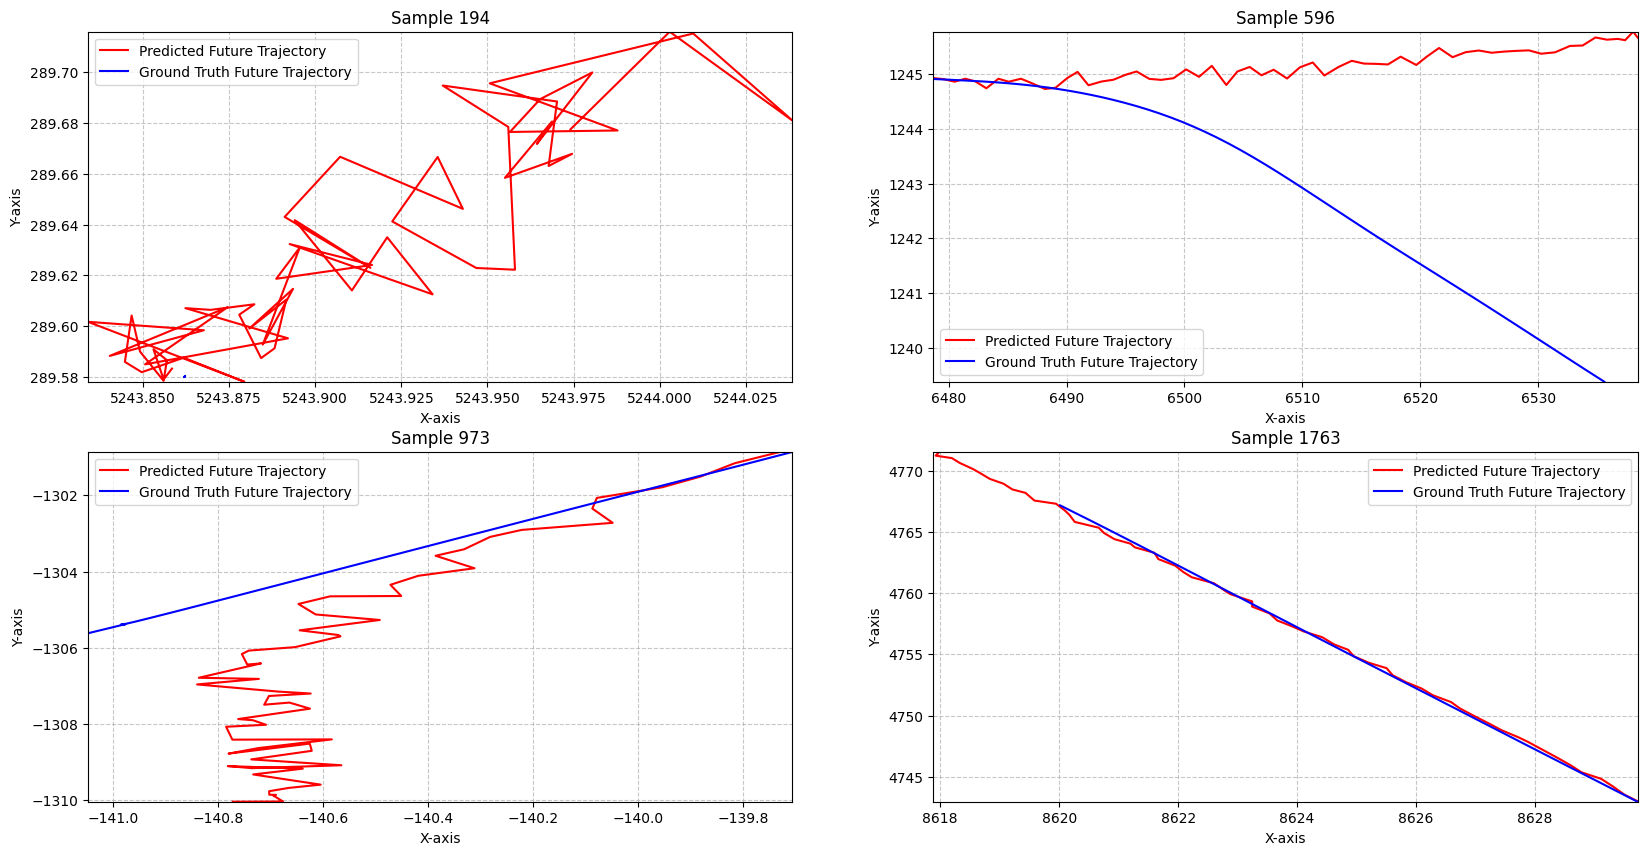

In [23]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [24]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = PureS4TrajectoryModel(dropout=0).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B